<div style="display: flex; background-color: #3F579F;">
    <h1 style="margin: auto; font-weight: bold; padding: 30px 30px 0px 30px;" align="center">Consumption needs of buildings - Project 4</h1>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 5px 30px 0px 30px;" >
    <h2 style="width: 100%; text-align: center; float: left;" align="center">| Analysis notebook |</h2>
</div>
<div style="display: flex; background-color: #3F579F; margin: auto; padding: 10px 30px 30px 30px;">
    <h3 style="width: 100%; text-align: center; font-size:26px; float: left;" align="center">Data Scientist course - OpenClassrooms</h3>
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">1. Libraries and functions</h3>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">1.1. Libraries and functions</h3>
</div>

In [1]:
import io
import gc
import ast
import datetime
from math import prod
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn import decomposition
from sklearn.decomposition import PCA

from functions import *

%matplotlib inline
sns.set_theme(style="darkgrid")

SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">1.2. Functions declaration</h4>
</div>

In [2]:
def df_analysis(df, name_df, *args, **kwargs):
    """
    Method used to analyze on the DataFrame.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze
        name_df (str): Dataset name
        
        *args, **kwargs:
        -----------------
            columns (list): Dataframe keys in list format
            flag (str): Flag to show complete information about the dataset to analyse
                        "complete" shows all information about the dataset

    Returns:
    -----------------
        None. 
        Print the analysis on the Dataset. 
    """
    
    # Getting the variables
    columns = kwargs.get("columns", None)
    type_analysis = kwargs.get("type_analysis", None)
    
    ORDERING_COMPLETE = [
        "name", "type", "records", "unique", "# NaN", "% NaN", "mean", "min", "25%", "50%", "75%", "max", "std"
    ]
    
    # Calculating the memory usage based on dataframe.info()
    buf = io.StringIO()
    df.info(buf=buf)
    memory_usage = buf.getvalue().split('\n')[-2]
    
    if df.empty:
        print("The", name_df, "dataset is empty. Please verify the file.")
    else:
        empty_cols = [col for col in df.columns if df[col].isna().all()] # identifying empty columns
        df_rows_duplicates = df[df.duplicated()] #identifying full duplicates rows
        
        # Creating a dataset based on Type object and records by columns
        type_cols = df.dtypes.apply(lambda x: x.name).to_dict() 
        df_resume = pd.DataFrame(list(type_cols.items()), columns = ["name", "type"])
        df_resume["records"] = list(df.count())
        df_resume["# NaN"] = list(df.isnull().sum())
        df_resume["% NaN"] = list(((df.isnull().sum() / len(df.index))*100).round(2))
        
        print("\nAnalysis of", name_df, "dataset")
        print("--------------------------------------------------------------------")
        print("- Dataset shape:                 ", df.shape[0], "rows and", df.shape[1], "columns")
        print("- Total of NaN values:           ", df.isna().sum().sum())
        print("- Percentage of NaN:             ", round((df.isna().sum().sum() / prod(df.shape)) * 100, 2), "%")
        print("- Total of full duplicates rows: ", df_rows_duplicates.shape[0])
        print("- Total of empty rows:           ", df.shape[0] - df.dropna(axis="rows", how="all").shape[0]) if df.dropna(axis="rows", how="all").shape[0] < df.shape[0] else \
                    print("- Total of empty rows:            0")
        print("- Total of empty columns:        ", len(empty_cols))
        print("  + The empty column is:         ", empty_cols) if len(empty_cols) == 1 else \
                    print("  + The empty column are:         ", empty_cols) if len(empty_cols) >= 1 else None
        print("- Unique indexes:                ", df.index.is_unique)
        
        if columns is not None:
            print("\n- The key(s):", columns, "is not present multiple times in the dataframe.\n  It CAN be used as a primary key.") if df.size == df.drop_duplicates(columns).size else \
                print("\n- The key(s):", columns, "is present multiple times in the dataframe.\n  It CANNOT be used as a primary key.")
        
        if type_analysis == "summarized":
            print("\n")
        
        if type_analysis is None or type_analysis != "summarized":
            pd.set_option("display.max_rows", None) # show full of showing rows
            pd.set_option("display.max_columns", None) # show full of showing cols
            pd.set_option("display.max_colwidth", None) # show full width of showing cols
            pd.set_option("display.float_format", lambda x: "%.5f" % x) # show full content in cell    
            
            if type_analysis is None or type_analysis != "complete":
                print("\n- Type object and records by columns      (",memory_usage,")")
                print("--------------------------------------------------------------------")
            elif type_analysis == "complete":
                df_resume["unique"] = list(df.nunique())
                df_desc = pd.DataFrame(df.describe().T).reset_index()
                df_desc = df_desc.rename(columns={"index": "name"})
                df_resume = df_resume.merge(right=df_desc[["name", "mean", "min", "25%", "50%", "75%", "max", "std"]], on="name", how="left")
                df_resume = df_resume[ORDERING_COMPLETE]
                print("\n- Type object and records by columns      (",memory_usage,")")
                print("--------------------------------------------------------------------")
                
            display(df_resume.sort_values("records", ascending=False))
            
            pd.reset_option("display.max_rows") # reset max of showing rows
            pd.reset_option("display.max_columns") # reset max of showing cols
            pd.reset_option("display.max_colwidth") # reset width of showing cols
            pd.reset_option("display.float_format") # reset show full content in cell
            
        # deleting dataframe to free memory
        if type_analysis == "complete":
            del [[df_resume, df_desc]]
            gc.collect()
            df_resume, df_desc = (pd.DataFrame() for i in range(2))
        else:
            del df_resume
            gc.collect()
            df_resume = pd.DataFrame()


def comparing_columns_df():
    """
    Method used to identify columns that do not match between datasets

    Returns:
    -----------------
        df (pandas.DataFrame): Dataframe with columns that do not match
    """

    LIST_COL, LIST_ORIGIN = ([] for i in range(2))

    for col in data_2015.columns:
        if col not in list(data_2016.columns):
            LIST_COL.append(col)
            LIST_ORIGIN.append("data_2015")

    for col in data_2016.columns:
        if col not in list(data_2015.columns):
            LIST_COL.append(col)
            LIST_ORIGIN.append("data_2016")

    df = pd.DataFrame({
        "column": LIST_COL,
        "origin": LIST_ORIGIN
    })
    
    display(df.sort_values("column"))
    
    return df


def types_different():
    """
    Method used to identify the same columns with different dtypes

    Returns:
    -----------------
        None. 
        Print the tests on a new Dataset. 
    """
    
    COLS_2015, COLS_2016, LIST_COL_DIFFERENT, LIST_DTYPE_2015, LIST_DTYPE_2016 = [[] for i in range(5)]
    
    for col in data_2015.columns:
        if col not in list(df_columns_not_matches.loc[df_columns_not_matches["origin"]=="data_2015", "column"]):         
            COLS_2015.append(col)
    for col in data_2016.columns:
        if col not in list(df_columns_not_matches.loc[df_columns_not_matches["origin"]=="data_2016", "column"]):
            COLS_2016.append(col)
    
    for col_2015, col_2016 in zip(COLS_2015, COLS_2016):
        if data_2015[col_2015].dtype != data_2016[col_2016].dtype:
            LIST_COL_DIFFERENT.append(col_2015)
            LIST_DTYPE_2015.append(str(data_2015[col_2015].dtype))
            LIST_DTYPE_2016.append(str(data_2016[col_2016].dtype))
            
    df_types_different = pd.DataFrame({
                            "column": LIST_COL_DIFFERENT,
                            "2015": LIST_DTYPE_2015,
                            "2016": LIST_DTYPE_2016
                        })
    
    return display(df_types_different.sort_values("column"))
            
            
def normality_test(df):
    """
    Method used to make the normality test.

    Parameters:
    -----------------
        df (pandas.DataFrame): Dataset to analyze

    Returns:
    -----------------
        None. 
        Print the tests on a new Dataset. 
    """
    
    list_test = {
        "Shapiro-Wilk":stats.shapiro, "D’Agostino’s K^2":stats.normaltest,
        "Kolmogorov-Smirnov":stats.kstest
    }
    
    
    alpha = 0.05
    fail_to_reject_H = "Sample looks Gaussian (fail to reject H0)"
    reject_H = "Sample does not look Gaussian (reject H0)"
    
    variable, test_name, result, hypothesis = [[] for i in range(4)]
    
    for key, value in list_test.items():
    
        for col in df.columns:
            
            if df[col].dtypes == "float64" or df[col].dtypes == "int64":
                variable.append(col)
                test_name.append(key)
                
                if key == "Kolmogorov-Smirnov":
                    stat, p_value = value(df[col], cdf="norm")
                else:
                    stat, p_value = value(df[col])
                    
                result.append("Statistics=%.3f, p-value=%.3f" % (stat, p_value))
                hypothesis.append(fail_to_reject_H.translate(SUB)) if p_value > alpha else hypothesis.append(reject_H.translate(SUB))
                
    df_normality_test = pd.DataFrame({
                            "variable": variable,
                            "normality test": test_name, 
                            "result": result,
                            "hypothesis": hypothesis})
    
    display(df_normality_test)
    

class GroupImputer(BaseEstimator, TransformerMixin):
    """ 
    Class used for imputing missing values in a pd.DataFrame using either mean or median of a group.
    
    Parameters:
    -----------------  
        group_cols (list) : List of columns used for calculating the aggregated value 
        strategy (str) : The strategy to be used for remplacement, can be one of ["mean", "median", "mode"]
        
    Returns:
    -----------------
        X (array-like) : The array with imputed values in the target column
   """    
    
    def __init__(self, group_cols, target, strategy="mean"):
        
        assert strategy in ["mean", "median"], "Unrecognized value for metric, should be mean/median"
        assert type(group_cols) == list, "group_cols should be a list of columns"
        assert type(target) == list, "target should be a string"
        
        self.group_cols = group_cols
        self.target = target
        self.strategy = strategy
    
    def fit(self, X, y=None):
        
        assert pd.isnull(X[self.group_cols]).any(axis=None) == False, "There are missing values in group_cols"
        
        impute_map = X.groupby(self.group_cols)[self.target].agg(self.strategy) \
                                                            .reset_index(drop=False)
        
        self.impute_map_ = impute_map
        
        return self 
    
    def transform(self, X, y=None):
        
        # make sure that the imputer was fitted
        check_is_fitted(self, "impute_map_")
        
        X = X.copy()
        
        for index, row in self.impute_map_.iterrows():
            ind = (X[self.group_cols] == row[self.group_cols]).all(axis=1)
            X.loc[ind, self.target] = X.loc[ind, self.target].fillna(row[self.target])
        
        return X.values

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">2. Importing files</h3>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">2.1. Importing and preparing files</h4>
</div>

<div class="alert alert-block alert-info">
    Based on the <b>official site of Seattle Open Data</b>, we can see the dataset <b>metadata</b> to know all features
    
    <ul style="list-style-type: square;">
        <li><b>2015: https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m</b></li>
        <li><b>2016: https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy</b></li>
    </ul>  
    
    On the other hand, we get the means of <b>Energy Star Score</b>
    <ul style="list-style-type: square;">
        <li><b>Energy Star Score: https://www.energystar.gov/buildings/benchmark/analyze_benchmarking_results</b></li>
    </ul>  
</div>

In [3]:
data_2015 = pd.read_csv(r"datasets\2015-building-energy-benchmarking.csv")
data_2016 = pd.read_csv(r"datasets\2016-building-energy-benchmarking.csv")

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">2.2. Initial analysis</h4>
</div>

<div class="alert alert-block alert-info">
Making <b>the initial analysis</b>
</div>

In [4]:
df_analysis(data_2015, "data_2015")


Analysis of data_2015 dataset
--------------------------------------------------------------------
- Dataset shape:                  3340 rows and 47 columns
- Total of NaN values:            26512
- Percentage of NaN:              16.89 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 1.2+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,OSEBuildingID,int64,3340,0,0.00000
9,YearBuilt,int64,3340,0,0.00000
40,ComplianceStatus,object,3340,0,0.00000
1,DataYear,int64,3340,0,0.00000
14,PropertyGFABuilding(s),int64,3340,0,0.00000
13,PropertyGFAParking,int64,3340,0,0.00000
12,PropertyGFATotal,int64,3340,0,0.00000
10,NumberofBuildings,int64,3340,0,0.00000
46,Zip Codes,int64,3340,0,0.00000
8,Neighborhood,object,3340,0,0.00000


In [5]:
df_analysis(data_2016, "data_2016")


Analysis of data_2016 dataset
--------------------------------------------------------------------
- Dataset shape:                  3376 rows and 46 columns
- Total of NaN values:            19952
- Percentage of NaN:              12.85 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         1
  + The empty column is:          ['Comments']
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 1.2+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,OSEBuildingID,int64,3376,0,0.00000
11,Neighborhood,object,3376,0,0.00000
1,DataYear,int64,3376,0,0.00000
40,DefaultData,bool,3376,0,0.00000
42,ComplianceStatus,object,3376,0,0.00000
19,PropertyGFABuilding(s),int64,3376,0,0.00000
18,PropertyGFAParking,int64,3376,0,0.00000
17,PropertyGFATotal,int64,3376,0,0.00000
14,YearBuilt,int64,3376,0,0.00000
13,Longitude,float64,3376,0,0.00000


<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">3. Cleaning</h3>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.1. Formatting columns in both datasets</h4>
</div>

<div class="alert alert-block alert-info">
    We are going to <b>concatenate both datasets</b> and keeping only the <b>unique values</b>. But first, we must know deeply the datastes.
</div>
<div class="alert alert-block alert-info">
    Based on the <b>official site of Seattle Open Data</b>, we can <b>identify similar features</b> between datasets
    
     <ul style="list-style-type: square;">
        <li><b>GHGEmissions(MetricTonsCO2e)</b> in <b>data_2015</b> is the same feature as <b>TotalGHGEmissions</b> in <b>data_2016</b></li>
        <li><b>GHGEmissionsIntensity(kgCO2e/ft2)</b> in <b>data_2015</b> is the same feature as <b>GHGEmissionsIntensity</b> in <b>data_2016</b></li>
    </ul>
    
     On the other hands, we have the following
    <ul style="list-style-type: square;">
        <li><b>Zip Codes</b> in <b>data_2015</b> is the same feature as <b>ZipCode</b> in <b>data_2016</b></li>
    </ul>
</div>

In [6]:
data_2015["ZipCode"] = data_2015["Zip Codes"]
data_2016["GHGEmissionsIntensity(kgCO2e/ft2)"] = data_2016["GHGEmissionsIntensity"]
data_2016["GHGEmissions(MetricTonsCO2e)"] = data_2016["TotalGHGEmissions"]

data_2015.drop(labels=["Zip Codes"], axis=1, inplace=True)
data_2016.drop(labels=["GHGEmissionsIntensity", "TotalGHGEmissions"], axis=1, inplace=True)

<div class="alert alert-block alert-info">
    Splitting the featured <b>Location</b> in <b>data_2015</b>
</div>

In [7]:
df_temp = data_2015["Location"].apply(lambda x: ast.literal_eval(x))
data_2015[["Latitude", "Longitude", "Address"]] = df_temp.apply(pd.Series)

<div class="alert alert-block alert-info">
<b>Comparing</b> the match between columns <b>before</b> making the <b>concatenation</b>
</div>

In [8]:
df_columns_not_matches = comparing_columns_df()

,column,origin
3,2010 Census Tracts,data_2015
7,City,data_2016
5,City Council Districts,data_2015
2,Comment,data_2015
9,Comments,data_2016
0,Location,data_2015
1,OtherFuelUse(kBtu),data_2015
6,SPD Beats,data_2015
4,Seattle Police Department Micro Community Poli...,data_2015
8,State,data_2016


<div class="alert alert-block alert-success">
    At this point, we get all columns that do <b>not match between the datasets</b>. Most of them seem not to have <b>importance</b> unlike <b>OtherFuelUse(kBtu)</b>
</div>

<div class="alert alert-block alert-info">
    <b>Eliminate</b> the columns that do not matched between the two datasets because they are not interesting for the mission<br>
    But, keeping the column <b>OtherFuelUse(kBtu)</b>
</div>

In [9]:
COLUMNS_NOT_MACTCH_2015 = list(df_columns_not_matches.loc[(df_columns_not_matches["origin"]=="data_2015") & (df_columns_not_matches["column"]!="OtherFuelUse(kBtu)"), "column"])
COLUMNS_NOT_MACTCH_2016 = list(df_columns_not_matches.loc[df_columns_not_matches["origin"]=="data_2016", "column"])

In [10]:
data_2015.drop(labels=COLUMNS_NOT_MACTCH_2015, axis=1, inplace=True)
data_2016.drop(labels=COLUMNS_NOT_MACTCH_2016, axis=1, inplace=True)

In [11]:
df_columns_not_matches = comparing_columns_df()

,column,origin
0,OtherFuelUse(kBtu),data_2015


<div class="alert alert-block alert-info">
<b>Comparing</b> the types of each par of column <b>before</b> making the <b>concatenation</b>
    
</div>

In [12]:
data_2015 = data_2015.reindex(sorted(data_2015.columns), axis=1)
data_2016 = data_2016.reindex(sorted(data_2016.columns), axis=1)

In [13]:
types_different()

,column,2015,2016
0,DefaultData,object,bool
1,Latitude,object,float64
2,Longitude,object,float64
3,NumberofBuildings,int64,float64
4,NumberofFloors,float64,int64
5,ZipCode,int64,float64


<div class="alert alert-block alert-info">
    <b>Fixing column types</b><br>
</div>

In [14]:
data_2015["DefaultData"] = data_2015["DefaultData"].astype("bool")
data_2015["Latitude"] = data_2015["Latitude"].astype("float64")
data_2015["Longitude"] = data_2015["Longitude"].astype("float64")

data_2016["NumberofBuildings"] = data_2016["NumberofBuildings"].fillna(0)
data_2016["NumberofBuildings"] = data_2016["NumberofBuildings"].astype("int64")

data_2015["NumberofFloors"] = data_2015["NumberofFloors"].fillna(0)
data_2015["NumberofFloors"] = data_2015["NumberofFloors"].astype("int64")

data_2016["ZipCode"] = data_2016["ZipCode"].fillna(0)
data_2016["ZipCode"] = data_2016["ZipCode"].astype("int64")

types_different()

,column,2015,2016


<div class="alert alert-block alert-info">
    Adding <b>OtherFuelUse(kBtu)</b> into <b>data_2016</b> to match both datasets
</div>

In [15]:
df_columns_not_matches = comparing_columns_df()

,column,origin
0,OtherFuelUse(kBtu),data_2015


In [16]:
data_2016["OtherFuelUse(kBtu)"] = np.NaN

In [17]:
df_columns_not_matches = comparing_columns_df()

,column,origin


<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.2. Identifying and formatting categorical columns</h4>
</div>

<div class="alert alert-block alert-info">
    <b>First of all</b>, we are going to concat both dataset to easily work with all data
</div>

In [18]:
df_temp = pd.concat([data_2015, data_2016], ignore_index=True).reset_index(drop=True)

In [19]:
df_temp.shape

(6716, 44)

<div class="alert alert-block alert-info">
    List of <b>categorical</b> columns
</div>

In [20]:
list(set(df_temp.columns) - set(df_temp._get_numeric_data()))

['LargestPropertyUseType',
 'ComplianceStatus',
 'BuildingType',
 'PropertyName',
 'ThirdLargestPropertyUseType',
 'TaxParcelIdentificationNumber',
 'Neighborhood',
 'PrimaryPropertyType',
 'SecondLargestPropertyUseType',
 'YearsENERGYSTARCertified',
 'Outlier',
 'Address',
 'ListOfAllPropertyUseTypes']

In [21]:
df_temp[list(set(df_temp.columns) - set(df_temp._get_numeric_data()))].head(5)

,LargestPropertyUseType,ComplianceStatus,BuildingType,PropertyName,ThirdLargestPropertyUseType,TaxParcelIdentificationNumber,Neighborhood,PrimaryPropertyType,SecondLargestPropertyUseType,YearsENERGYSTARCertified,Outlier,Address,ListOfAllPropertyUseTypes
0,Hotel,Compliant,NonResidential,MAYFLOWER PARK HOTEL,NaN,659000030,DOWNTOWN,Hotel,NaN,NaN,NaN,"{""address"": ""405 OLIVE WAY"", ""city"": ""SEATTLE""...",Hotel
1,Hotel,Compliant,NonResidential,PARAMOUNT HOTEL,Restaurant,659000220,DOWNTOWN,Hotel,Parking,NaN,NaN,"{""address"": ""724 PINE ST"", ""city"": ""SEATTLE"", ...","Hotel, Parking, Restaurant"
2,Hotel,Compliant,NonResidential,WESTIN HOTEL,Swimming Pool,659000475,DOWNTOWN,Hotel,Parking,NaN,NaN,"{""address"": ""1900 5TH AVE"", ""city"": ""SEATTLE"",...","Hotel, Parking, Swimming Pool"
3,Hotel,Compliant,NonResidential,HOTEL MAX,NaN,659000640,DOWNTOWN,Hotel,NaN,NaN,High Outlier,"{""address"": ""620 STEWART ST"", ""city"": ""SEATTLE...",Hotel
4,Hotel,Compliant,NonResidential,WARWICK SEATTLE HOTEL,Swimming Pool,659000970,DOWNTOWN,Hotel,Parking,NaN,NaN,"{""address"": ""401 LENORA ST"", ""city"": ""SEATTLE""...","Hotel, Parking, Swimming Pool"


<div class="alert alert-block alert-warning">
    <b>TaxParcelIdentificationNumber</b> is a <b>numeric</b> column instead of <b>categorical</b> column
</div>

<div class="alert alert-block alert-info">
    Now, we are going to verify the data in <b>categorical</b> columns
</div>

In [22]:
for col in list(set(df_temp.columns) - set(df_temp._get_numeric_data())):
    print(col)
    display(df_temp[col].unique())

LargestPropertyUseType


array(['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly',
       'Multifamily Housing', nan, 'Library',
       'Fitness Center/Health Club/Gym', 'Social/Meeting Hall',
       'Courthouse', 'Other', 'K-12 School', 'College/University',
       'Automobile Dealership', 'Office', 'Self-Storage Facility',
       'Retail Store', 'Senior Care Community', 'Medical Office',
       'Hospital (General Medical & Surgical)', 'Museum',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Residence Hall/Dormitory',
       'Other/Specialty Hospital', 'Financial Office',
       'Non-Refrigerated Warehouse', 'Distribution Center', 'Parking',
       'Worship Facility', 'Laboratory', 'Supermarket/Grocery Store',
       'Convention Center', 'Urgent Care/Clinic/Other Outpatient',
       'Other - Services', 'Strip Mall', 'Wholesale Club/Supercenter',
       'Refrigerated Warehouse', 'Other - Recreation', 'Lifestyle Center',
       'Other - Public S

ComplianceStatus


array(['Compliant', 'Not Compliant', 'Error - Correct Default Data',
       'Missing Data', 'Non-Compliant'], dtype=object)

BuildingType


array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Multifamily LR (1-4)', 'Campus',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

PropertyName


array(['MAYFLOWER PARK HOTEL', 'PARAMOUNT HOTEL', 'WESTIN HOTEL', ...,
       'Queen Anne Pool', 'South Park Community Center',
       'Van Asselt Community Center'], dtype=object)

ThirdLargestPropertyUseType


array([nan, 'Restaurant', 'Swimming Pool', 'Data Center', 'Office',
       'Retail Store', 'Other - Entertainment/Public Assembly', 'Other',
       'Distribution Center', 'Food Service', 'Other - Services',
       'Medical Office', 'Parking', 'Other - Lodging/Residential',
       'K-12 School', 'Fitness Center/Health Club/Gym',
       'Social/Meeting Hall', 'Pre-school/Daycare',
       'Convenience Store without Gas Station', 'Financial Office',
       'Non-Refrigerated Warehouse', 'Other - Restaurant/Bar',
       'Other - Education', 'Multifamily Housing', 'Laboratory',
       'Bank Branch', 'Hotel', 'Other - Recreation',
       'Personal Services (Health/Beauty, Dry Cleaning, etc)',
       'Self-Storage Facility', 'Other - Technology/Science',
       'Refrigerated Warehouse', 'Manufacturing/Industrial Plant',
       'Fast Food Restaurant', 'Bar/Nightclub', 'Food Sales',
       'Supermarket/Grocery Store', 'Other/Specialty Hospital',
       'Worship Facility', 'Strip Mall', 'Enclosed 

TaxParcelIdentificationNumber


array(['659000030', '659000220', '659000475', ..., '1624049080',
       '7883603155', '7857002030'], dtype=object)

Neighborhood


array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'CENTRAL', 'NORTH',
       'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'GREATER DUWAMISH',
       'BALLARD', 'NORTHWEST', 'SOUTHWEST', 'DELRIDGE', 'Central',
       'Ballard', 'North', 'Delridge', 'Northwest',
       'DELRIDGE NEIGHBORHOODS'], dtype=object)

PrimaryPropertyType


array(['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property',
       'K-12 School', 'College/University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility\n', 'Distribution Center', 'Large Office',
       'Retail Store', 'Low-Rise Multifamily', 'Senior Care Community',
       'Medical Office', 'Hospital', 'Residence Hall/Dormitory',
       'Non-Refrigerated Warehouse', 'Distribution Center\n',
       'SPS-District K-12', 'Worship Facility',
       'Supermarket/Grocery Store', 'Laboratory', 'Self-Storage Facility',
       'Refrigerated Warehouse', 'High-Rise Multifamily', 'Restaurant\n',
       'Restaurant', 'University', 'Warehouse', 'Residence Hall',
       'Supermarket / Grocery Store', 'Office'], dtype=object)

SecondLargestPropertyUseType


array([nan, 'Parking', 'Office', 'Restaurant', 'K-12 School',
       'Non-Refrigerated Warehouse', 'Other - Education',
       'Vocational School', 'Retail Store',
       'Other - Entertainment/Public Assembly', 'Data Center',
       'Swimming Pool', 'Other', 'Courthouse', 'Residence Hall/Dormitory',
       'Distribution Center', 'Self-Storage Facility', 'Other - Services',
       'Laboratory', 'Movie Theater', 'Supermarket/Grocery Store',
       'Medical Office', 'Other - Recreation',
       'Convenience Store without Gas Station',
       'Fitness Center/Health Club/Gym', 'Performing Arts',
       'College/University', 'Other - Restaurant/Bar', 'Adult Education',
       'Multifamily Housing', 'Bar/Nightclub', 'Financial Office',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Bank Branch', 'Food Service',
       'Worship Facility', 'Senior Care Community',
       'Refrigerated Warehouse', 'Hotel', 'Food Sales',
       'Other/Specialty H

YearsENERGYSTARCertified


array([nan, '2016', '2014', '2012', '2015',
       '2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008',
       '2010, 2009, 2007', '2010, 2007', '2016, 2015', '2017, 2015',
       '2015, 2014, 2012, 2011, 2009', '2012, 2009, 2008',
       '2016, 2015, 2014, 2013, 2011, 2010, 2009, 2007, 2000',
       '2016, 2009, 2008', '2016, 2014, 2012',
       '2016, 2015, 2014, 2012, 2008',
       '2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004',
       '2014, 2013, 2011, 2010, 2009, 2008, 2007',
       '2016, 2015, 2014, 2013, 2011, 2008',
       '2016, 2015, 2014, 2013, 2008', '2016, 2015, 2013, 2012, 2010',
       '2015, 2013, 2012, 2010', '2007', '2010', '2016, 2015, 2009, 2008',
       '2013, 2009, 2008', '2017', '2017, 2011, 2010, 2007',
       '2017, 2016, 2014, 2013, 2012, 2011, 2010, 2009, 2007',
       '2015, 2014, 2012, 2010, 2008', '2012, 2010, 2009, 2008',
       '2009, 2005', '2017, 2015, 2014, 2013', '2016, 2015, 2012',
       '2012, 2010, 2007, 2006'

Outlier


array([nan, 'High Outlier', 'Low Outlier', 'High outlier', 'Low outlier'],
      dtype=object)

Address


array(['{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}',
       '{"address": "724 PINE ST", "city": "SEATTLE", "state": "WA", "zip": "98101"}',
       '{"address": "1900 5TH AVE", "city": "SEATTLE", "state": "WA", "zip": "98101"}',
       ..., '1920 1st Ave W', '8319 8th Ave S', '2820 S Myrtle St'],
      dtype=object)

ListOfAllPropertyUseTypes


array(['Hotel', 'Hotel, Parking, Restaurant',
       'Hotel, Parking, Swimming Pool', 'Police Station',
       'Other - Entertainment/Public Assembly', 'Multifamily Housing',
       nan, 'Hotel, Parking', 'Data Center, Library, Parking',
       'Fitness Center/Health Club/Gym, Office, Swimming Pool',
       'Office, Other, Other - Lodging/Residential, Restaurant, Social/Meeting Hall',
       'Courthouse', 'Other', 'K-12 School', 'College/University',
       'Automobile Dealership',
       'Hotel, Parking, Retail Store, Swimming Pool',
       'K-12 School, Multifamily Housing, Office, Other - Entertainment/Public Assembly',
       'Self-Storage Facility', 'Non-Refrigerated Warehouse, Office',
       'Office, Other - Education',
       'Office, Self-Storage Facility, Vocational School',
       'Data Center, Office, Retail Store',
       'Non-Refrigerated Warehouse, Other, Retail Store',
       'Office, Retail Store',
       'Office, Other - Entertainment/Public Assembly, Restaurant',
   

<div class="alert alert-block alert-success">
    At this point, we get that all <b>categorical</b> columns have more than one type of value
</div>

<div class="alert alert-block alert-info">
    <b>Cleaning</b> data in the features
</div>

In [23]:
df_temp["ComplianceStatus"].replace("Non-Compliant", "Not Compliant", inplace=True)
df_temp["ComplianceStatus"].replace("Missing Data", np.nan, inplace=True)
df_temp["ComplianceStatus"].replace("Error - Correct Default Data", np.nan, inplace=True)

df_temp["Neighborhood"].replace("Ballard", "BALLARD", inplace=True)
df_temp["Neighborhood"].replace("Central", "CENTRAL", inplace=True)
df_temp["Neighborhood"].replace("North", "NORTH", inplace=True)
df_temp["Neighborhood"].replace("Delridge", "DELRIDGE", inplace=True)
df_temp["Neighborhood"].replace("DELRIDGE NEIGHBORHOODS", "DELRIDGE", inplace=True)
df_temp["Neighborhood"].replace("Northwest", "NORTHWEST", inplace=True)

df_temp["PrimaryPropertyType"].replace("Restaurant\n", "Restaurant", inplace=True)
df_temp["PrimaryPropertyType"].replace("Self-Storage Facility\n", "Self-Storage Facility", inplace=True)
df_temp["PrimaryPropertyType"].replace("Distribution Center\n", "Distribution Center", inplace=True)
df_temp["PrimaryPropertyType"].replace("Small- and Mid-Sized Office", "Small and Mid-Sized Office", inplace=True)
df_temp["PrimaryPropertyType"].replace("Supermarket / Grocery Store", "Supermarket/Grocery Store", inplace=True)

<div class="alert alert-block alert-info">
    <b>Changing</b> the type of data <b>Neighborhood</b>
</div>

In [24]:
for col in list(set(df_temp.columns) - set(df_temp._get_numeric_data())):
    if col != "TaxParcelIdentificationNumber":
        df_temp[col] = df_temp[col].astype("category")

In [25]:
df_analysis(df_temp, "df_temp")


Analysis of df_temp dataset
--------------------------------------------------------------------
- Dataset shape:                  6716 rows and 44 columns
- Total of NaN values:            36985
- Percentage of NaN:              12.52 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 2.3+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,Address,category,6716,0,0.00000
15,Longitude,float64,6716,0,0.00000
41,YearBuilt,int64,6716,0,0.00000
28,PropertyName,category,6716,0,0.00000
27,PropertyGFATotal,int64,6716,0,0.00000
26,PropertyGFAParking,int64,6716,0,0.00000
25,PropertyGFABuilding(s),int64,6716,0,0.00000
24,PrimaryPropertyType,category,6716,0,0.00000
1,BuildingType,category,6716,0,0.00000
21,OSEBuildingID,int64,6716,0,0.00000


<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.3. Filtering information</h4>
</div>

<div class="alert alert-block alert-info">
    We continue to work with all data (2015 & 2016) to easily work with all data<br><br>
    
    Based on the mision, we are going to <b>filter</b> the <b>types of building</b> considering only <b>"non residential" buildings</b><br>
    First of all, we should know in which columns we must make focus
</div>

In [26]:
LIST_PROPERTY_COLS = []

for col in df_temp.columns:
    if "Property" in col or "Building" in col:
        LIST_PROPERTY_COLS.append(col)
        
LIST_PROPERTY_COLS

['BuildingType',
 'LargestPropertyUseType',
 'LargestPropertyUseTypeGFA',
 'ListOfAllPropertyUseTypes',
 'NumberofBuildings',
 'OSEBuildingID',
 'PrimaryPropertyType',
 'PropertyGFABuilding(s)',
 'PropertyGFAParking',
 'PropertyGFATotal',
 'PropertyName',
 'SecondLargestPropertyUseType',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseType',
 'ThirdLargestPropertyUseTypeGFA']

In [27]:
df_temp[LIST_PROPERTY_COLS].head(5)

,BuildingType,LargestPropertyUseType,LargestPropertyUseTypeGFA,ListOfAllPropertyUseTypes,NumberofBuildings,OSEBuildingID,PrimaryPropertyType,PropertyGFABuilding(s),PropertyGFAParking,PropertyGFATotal,PropertyName,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA
0,NonResidential,Hotel,88434.0,Hotel,1,1,Hotel,88434,0,88434,MAYFLOWER PARK HOTEL,NaN,NaN,NaN,NaN
1,NonResidential,Hotel,83880.0,"Hotel, Parking, Restaurant",1,2,Hotel,88502,15064,103566,PARAMOUNT HOTEL,Parking,15064.0,Restaurant,4622.0
2,NonResidential,Hotel,757243.0,"Hotel, Parking, Swimming Pool",1,3,Hotel,961990,0,961990,WESTIN HOTEL,Parking,100000.0,Swimming Pool,0.0
3,NonResidential,Hotel,61320.0,Hotel,1,5,Hotel,61320,0,61320,HOTEL MAX,NaN,NaN,NaN,NaN
4,NonResidential,Hotel,123445.0,"Hotel, Parking, Swimming Pool",1,8,Hotel,107430,12460,119890,WARWICK SEATTLE HOTEL,Parking,68009.0,Swimming Pool,0.0


<div class="alert alert-block alert-info">
    Based on <b>the percentage of missing-values</b> or the <b>amount of data</b> in each <b>categorical column</b>, we make focus on the following columns: 
    <ul style="list-style-type: square;">
        <li><b>BuildingType</b></li>
        <li><b>PrimaryPropertyType</b></li>
        <li><b>LargestPropertyUseType</b></li>
    </ul> 
</div>

<div class="alert alert-block alert-info">
    Filtering by <b>BuildingType</b> and <b>"non residential"</b> buildings
</div>

In [28]:
list(df_temp["BuildingType"].unique())

['NonResidential',
 'Nonresidential COS',
 'Multifamily MR (5-9)',
 'SPS-District K-12',
 'Multifamily LR (1-4)',
 'Campus',
 'Multifamily HR (10+)',
 'Nonresidential WA']

In [29]:
df_temp = pd.DataFrame(df_temp[~df_temp["BuildingType"].str.contains("family", case=False, na=False).any(level=0)])

In [30]:
df_analysis(df_temp, "df_temp", type_analysis="summarized")


Analysis of df_temp dataset
--------------------------------------------------------------------
- Dataset shape:                  3318 rows and 44 columns
- Total of NaN values:            18180
- Percentage of NaN:              12.45 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True




<div class="alert alert-block alert-info">
    Filtering by <b>PrimaryPropertyType</b> and <b>"non residential"</b> buildings
</div>

In [31]:
list(df_temp["PrimaryPropertyType"].unique())

['Hotel',
 'Other',
 'Mixed Use Property',
 'K-12 School',
 'College/University',
 'Small and Mid-Sized Office',
 'Self-Storage Facility',
 'Distribution Center',
 'Large Office',
 'Retail Store',
 'Senior Care Community',
 'Medical Office',
 'Hospital',
 'Residence Hall/Dormitory',
 'Non-Refrigerated Warehouse',
 'SPS-District K-12',
 'Worship Facility',
 'Supermarket/Grocery Store',
 'Laboratory',
 'Refrigerated Warehouse',
 'Restaurant',
 'Low-Rise Multifamily',
 'University',
 'Warehouse',
 'Residence Hall',
 'Office']

In [32]:
df_temp = df_temp[~df_temp["PrimaryPropertyType"].isin(["Residence Hall", "Residence Hall/Dormitory", "Low-Rise Multifamily"])]

In [33]:
df_analysis(df_temp, "df_temp", type_analysis="summarized")


Analysis of df_temp dataset
--------------------------------------------------------------------
- Dataset shape:                  3277 rows and 44 columns
- Total of NaN values:            17943
- Percentage of NaN:              12.44 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True




<div class="alert alert-block alert-info">
    Filtering by <b>LargestPropertyUseType</b> and <b>"non residential"</b> buildings
</div>

In [34]:
list(df_temp["LargestPropertyUseType"].unique())

['Hotel',
 'Police Station',
 'Other - Entertainment/Public Assembly',
 nan,
 'Library',
 'Fitness Center/Health Club/Gym',
 'Social/Meeting Hall',
 'Courthouse',
 'Other',
 'K-12 School',
 'College/University',
 'Automobile Dealership',
 'Office',
 'Self-Storage Facility',
 'Retail Store',
 'Senior Care Community',
 'Medical Office',
 'Hospital (General Medical & Surgical)',
 'Museum',
 'Repair Services (Vehicle, Shoe, Locksmith, etc)',
 'Other - Lodging/Residential',
 'Other/Specialty Hospital',
 'Financial Office',
 'Non-Refrigerated Warehouse',
 'Distribution Center',
 'Parking',
 'Multifamily Housing',
 'Worship Facility',
 'Laboratory',
 'Supermarket/Grocery Store',
 'Convention Center',
 'Urgent Care/Clinic/Other Outpatient',
 'Other - Services',
 'Strip Mall',
 'Wholesale Club/Supercenter',
 'Refrigerated Warehouse',
 'Other - Recreation',
 'Lifestyle Center',
 'Other - Public Services',
 'Data Center',
 'Other - Mall',
 'Manufacturing/Industrial Plant',
 'Restaurant',
 'Other 

In [35]:
df_temp = df_temp[~df_temp["LargestPropertyUseType"].isin(["Other - Lodging/Residential", "Multifamily Housing", "Residence Hall/Dormitory"])]

In [36]:
df_analysis(df_temp, "df_temp")


Analysis of df_temp dataset
--------------------------------------------------------------------
- Dataset shape:                  3247 rows and 44 columns
- Total of NaN values:            17812
- Percentage of NaN:              12.47 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 1.5+ MB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,Address,category,3247,0,0.00000
15,Longitude,float64,3247,0,0.00000
41,YearBuilt,int64,3247,0,0.00000
28,PropertyName,category,3247,0,0.00000
27,PropertyGFATotal,int64,3247,0,0.00000
26,PropertyGFAParking,int64,3247,0,0.00000
25,PropertyGFABuilding(s),int64,3247,0,0.00000
24,PrimaryPropertyType,category,3247,0,0.00000
1,BuildingType,category,3247,0,0.00000
21,OSEBuildingID,int64,3247,0,0.00000


<div class="alert alert-block alert-success">
    At this point, we have <b>reduced the dataset</b> shape from <b>6716</b> to <b>3247 </b>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.4. Selecting the features</h4>
</div>

<div class="alert alert-block alert-info">
    Based on the <b>official site of Seattle Open Data</b>, we can see the dataset <b>metadata</b> to know all features
    
    <ul style="list-style-type: square;">
        <li><b>2015: https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m</b></li>
        <li><b>2016: https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy</b></li>
    </ul>  
       
    The <b>target variables</b> are:
    <ul style="list-style-type: square;">
        <li><b>SiteEnergyUse(kBtu):</b>The annual amount of energy consumed by the property from all sources of energy.</li>
        <li><b>GHGEmissions(MetricTonsCO2e):</b>The total amount of greenhouse gas emissions, including carbon dioxide, methane, and nitrous oxide gases released into the atmosphere as a result of energy consumption at the property, measured in metric tons of carbon dioxide equivalent. This calculation uses a GHG emissions factor from Seattle CIty Light's portfolio of generating resources. This uses Seattle City Light's 2015 emissions factor of 52.44 lbs CO2e/MWh. Enwave steam factor = 170.17 lbs CO2e/MMBtu. Gas factor sourced from EPA Portfolio Manager = 53.11 kg CO2e/MBtu.</li>
    </ul>  

On the other hand, we get the means of <b>Energy Star Score</b>
<ul style="list-style-type: square;">
    <li><b>Energy Star Score: https://www.energystar.gov/buildings/benchmark/analyze_benchmarking_results</b></li>
</ul>  
</div>

In [37]:
TARGET_VARIABLES = [
    "SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)"
]

In [38]:
OTHER_VARIABLE = [
    "ENERGYSTARScore"
]

In [39]:
DECLARATIVE_DATA = [
    "OSEBuildingID", "PropertyName", "Address", "Neighborhood", "NumberofBuildings", "NumberofFloors", 
    "DataYear", "YearBuilt", "BuildingType", "PrimaryPropertyType", "LargestPropertyUseType", 
    "PropertyGFABuilding(s)", "PropertyGFAParking", "PropertyGFATotal"
]

<div class="alert alert-block alert-info">
    The following features are being used to check the coherence of target variables
</div>

In [40]:
CONSUMPTION_VARIABLES = [
    "Electricity(kBtu)", "NaturalGas(kBtu)", "SteamUse(kBtu)", "OtherFuelUse(kBtu)"   
]

<div class="alert alert-block alert-info">
    Selecting the <b>features to work</b>
</div>

In [41]:
data = df_temp[DECLARATIVE_DATA + CONSUMPTION_VARIABLES + OTHER_VARIABLE + TARGET_VARIABLES].copy()

<div class="alert alert-block alert-info">
    We are going to <b>delete</b> the <b>target</b> variable observations with <b>missing-values</b>
</div>

In [42]:
data = pd.DataFrame(data[data[TARGET_VARIABLES].notnull().all(axis=1)]).reset_index(drop=True)

In [43]:
df_analysis(data, "data", columns=["OSEBuildingID"], type_analysis ="complete")


Analysis of data dataset
--------------------------------------------------------------------
- Dataset shape:                  3238 rows and 21 columns
- Total of NaN values:            2762
- Percentage of NaN:              4.06 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['OSEBuildingID'] is present multiple times in the dataframe.
  It CANNOT be used as a primary key.

- Type object and records by columns      ( memory usage: 1.0 MB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,OSEBuildingID,int64,3238,1659,0,0.00000,15768.31130,1.00000,573.25000,21091.50000,24488.00000,50226.00000,13408.43339
1,PropertyName,category,3238,3125,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,SiteEnergyUse(kBtu),float64,3238,3220,0,0.00000,8166073.60007,0.00000,1223328.25000,2522573.62500,7003998.25000,873923712.00000,25511472.92399
16,SteamUse(kBtu),float64,3238,225,0,0.00000,501333.61659,0.00000,0.00000,0.00000,0.00000,134943456.00000,5282771.91639
15,NaturalGas(kBtu),float64,3238,2308,0,0.00000,1893040.05035,0.00000,0.00000,471490.50000,1470246.50000,297909000.00000,7981067.96089
14,Electricity(kBtu),float64,3238,3225,0,0.00000,5708154.64950,-115417.00000,725335.75000,1637616.50000,4972411.25000,657074389.00000,17583093.79066
13,PropertyGFATotal,int64,3238,1631,0,0.00000,116533.33138,11285.00000,29662.00000,49744.00000,105775.00000,9320156.00000,252827.83284
12,PropertyGFAParking,int64,3238,354,0,0.00000,13456.21896,-2.00000,0.00000,0.00000,0.00000,512608.00000,44012.77635
11,PropertyGFABuilding(s),int64,3238,1655,0,0.00000,103077.11242,-50550.00000,28589.50000,47781.00000,94853.25000,9320156.00000,235770.34068
20,GHGEmissions(MetricTonsCO2e),float64,3238,2956,0,0.00000,179.02926,-0.80000,19.58000,49.02500,139.59000,16870.98000,673.42064


<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">3.4.1. Checking negatives values in the dataset</h5>
</div>

In [44]:
df_temp = data._get_numeric_data()

In [45]:
print("Number of negative values into dataset is:", df_temp[df_temp < 0].count().sum())

Number of negative values into dataset is: 5


<div class="alert alert-block alert-success">
    Despite there is only one negative value, we are going to <b>format</b> all dataframe with <b>absolute values</b>
</div>

In [46]:
for col in set(data._get_numeric_data()):
    data[col] = data[col].abs()

<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">3.4.2. Checking coherence of the gross floor area fields</h5>
</div>

<div class="alert alert-block alert-info">
    We are going to verify if the data is well distributed in the columns related to each other
</div>

In [47]:
data["checkingGFA"] = data["PropertyGFAParking"] + data["PropertyGFABuilding(s)"]

In [48]:
mask_GFA_out = ~data["checkingGFA"].between(data["PropertyGFATotal"]*0.90, data["PropertyGFATotal"]*1.1)

In [49]:
print(data[mask_GFA_out].shape[0], "of", data.shape[0], "do not have a correct PropertyGFATotal based on PropertyGFAParking and PropertyGFABuilding")

2 of 3238 do not have a correct PropertyGFATotal based on PropertyGFAParking and PropertyGFABuilding


<div class="alert alert-block alert-success">
    <b>PropertyGFATotal</b> is consistent based on their <b>related fields</b>
</div>

In [50]:
del data["checkingGFA"]

<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">3.4.3. Checking coherence of energy fields</h5>
</div>

<div class="alert alert-block alert-info">
    We are going to verify if the data is well distributed in the columns related to each other.<br>
</div>

In [51]:
data["checkingEnergy"] = data["Electricity(kBtu)"] + data["NaturalGas(kBtu)"] + data["SteamUse(kBtu)"] + data["OtherFuelUse(kBtu)"]

In [52]:
mask_Energy_out = ~data["checkingEnergy"].between(data["SiteEnergyUse(kBtu)"]*0.95, data["SiteEnergyUse(kBtu)"]*1.05)

In [53]:
print(data[mask_Energy_out].shape[0], "of", data.shape[0], "do not have a correct SiteEnergyUse(kBtu) based on Electricity(kBtu), NaturalGas(kBtu), SteamUse(kBtu) and OtherFuelUse(kBtu)")

1630 of 3238 do not have a correct SiteEnergyUse(kBtu) based on Electricity(kBtu), NaturalGas(kBtu), SteamUse(kBtu) and OtherFuelUse(kBtu)


<div class="alert alert-block alert-warning">
    <b>SiteEnergyUse(kBtu)</b> has many inconsistencies based on their <b>related fields</b>
</div>

In [54]:
df_energy_out = data[mask_Energy_out].copy()

In [55]:
df_energy_out.groupby("DataYear")["OSEBuildingID"].count()

DataYear
2015       3
2016    1627
Name: OSEBuildingID, dtype: int64

In [56]:
data[(data["DataYear"]==2015) & (data["SiteEnergyUse(kBtu)"]==0)].count().sum()

42

In [57]:
data[(data["DataYear"]==2016) & (data["SiteEnergyUse(kBtu)"]==0)].count().sum()

305

<div class="alert alert-block alert-success">
    <b>2015</b> data seem to be <b>better</b> than 2016 data.<br>
    It is something to consistent when we make choose the data to work
</div>

In [58]:
del data["checkingEnergy"]

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">3.5. Merging datasets considering duplicate buildings</h4>
</div>

<div class="alert alert-block alert-info">
    Now, it is necessary to <b>identify</b> those buildings <b>duplicates and not</b> between both datasets
</div>

In [59]:
in_2015 = data[data["DataYear"]==2015].copy()
in_2016 = data[data["DataYear"]==2016].copy()

In [60]:
in_2015.drop(labels=["Electricity(kBtu)", "NaturalGas(kBtu)", "SteamUse(kBtu)", "OtherFuelUse(kBtu)"], axis=1, inplace=True)
in_2016.drop(labels=["Electricity(kBtu)", "NaturalGas(kBtu)", "SteamUse(kBtu)", "OtherFuelUse(kBtu)"], axis=1, inplace=True)

In [61]:
in_common = in_2016.merge(in_2015, on="OSEBuildingID")
in_common = data[data["OSEBuildingID"].isin(in_common["OSEBuildingID"])].copy()

In [62]:
only_in_2015 = in_2015[~in_2015["OSEBuildingID"].isin(in_2016["OSEBuildingID"])]
only_in_2016 = in_2016[~in_2016["OSEBuildingID"].isin(in_2015["OSEBuildingID"])]

In [63]:
in_common.shape[0]

3158

In [64]:
only_in_2015.shape[0]

32

In [65]:
only_in_2016.shape[0]

48

<div class="alert alert-block alert-success">
    We got the following:
    <ul style="list-style-type: square;">
        <li>There are <b>3158 buildings duplicates</b></li>
        <li>There are <b>32 buildings only in 2015</b></li>
        <li>There are <b>48 buildings only in 2016</b></li>
    </ul>
    At the same time, when we checked the coherence of some fields, we got the following:
    <ul style="list-style-type: square;">
        <li><b>PropertyGFATotal</b> is <b>consistent for both years</b> (2015 and 2016) based on their related fields </li>
        <li><b>SiteEnergyUse(kBtu)</b> is only <b>consistent for 2015</b> based on their related fields </li>
    </ul>
    So, we are going to treat the data based on the following premise:

<ul style="list-style-type: square;">
    <li>For data in common</li>
        <ul style="list-style-type: disc;">
            <li> For <b>PropertyGFAParking</b>, <b>PropertyGFABuilding(s)</b> and <b>PropertyGFATotal</b> we are going to work only with <b>2016 data</b>, because they are more recent</li>
            <li> For <b>SiteEnergyUse(kBtu)</b>, <b>GHGEmissions(MetricTonsCO2e)</b> and <b>ENERGYSTARScore</b> we are going to work only with <b>2015
        data</b>, because they are more consistent</li>
            <li> For <b>NumberofBuildings</b> we are going to work only with <b>2015 data</b>, because they seem more consistent</li>
            
            
            
            <li>We are going to <b>combine</b> other features as follows</li>
                <ul style="list-style-type: circle;">
                    <li>Selecting most <b>recent value</b> by <b>Year</b> for <b>buildings</b> with data in 2015 and 2016</li>
                    <li>If the <b>value</b> is <b>np.NaN</b> or <b>0</b> so, we can <b>replace</b> it for <b>2015 value</b></li>
                </ul>
 
        </ul>
     <li><b>Concatenating</b> buildings that <b>are not</b> in <b>both datasets</b></li>
</ul>
</div>





<div class="alert alert-block alert-info">
    <b>Merging</b> building in both (2015 and 2016) datasets
</div>

In [66]:
in_common = in_2016.merge(in_2015, on="OSEBuildingID", suffixes=("_2016", "_2015"))

<div class="alert alert-block alert-info">
   <b>Features by year</b> to work
</div>

In [67]:
FEATURES_FROM_2015 = [
    "SiteEnergyUse(kBtu)_2015", "GHGEmissions(MetricTonsCO2e)_2015", "ENERGYSTARScore_2015", "NumberofBuildings_2015"
]
    
FEATURES_FROM_2016 = [    
    "OSEBuildingID", "PropertyName_2016", "Address_2016", "Neighborhood_2016", "NumberofFloors_2016", 
    "DataYear_2016", "YearBuilt_2016", "BuildingType_2016", "PrimaryPropertyType_2016", "LargestPropertyUseType_2016", 
    "PropertyGFABuilding(s)_2016", "PropertyGFAParking_2016", "PropertyGFATotal_2016"
]

In [68]:
in_common_subset = in_common[FEATURES_FROM_2016 + FEATURES_FROM_2015].copy()

In [69]:
# renaimg columns without suffix _2015 or _2016
for col in in_common_subset.columns:
    if "_201" in in_common_subset[col].name:
        in_common_subset[col[:-5]] = in_common_subset[col]
        del in_common_subset[col]

<div class="alert alert-block alert-success">
    <b>Concatenating</b> building only in 2015 and 2016<br/>
    <b>df_bebcs: Building Energy Benchmarking City of Seattled</b>
</div>

In [70]:
df_bebcs = pd.concat([in_common_subset, only_in_2015, only_in_2016], ignore_index=True)
del df_bebcs["DataYear"]

In [71]:
df_analysis(df_bebcs, "df_bebcs", columns=["OSEBuildingID"], type_analysis ="complete")


Analysis of df_bebcs dataset
--------------------------------------------------------------------
- Dataset shape:                  1659 rows and 16 columns
- Total of NaN values:            550
- Percentage of NaN:              2.07 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['OSEBuildingID'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns      ( memory usage: 766.4 KB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,OSEBuildingID,int64,1659,1659,0,0.00000,16110.99638,1.00000,578.50000,21119.00000,24553.50000,50226.00000,13751.99124
1,PropertyName,category,1659,1655,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Address,category,1659,1639,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Neighborhood,category,1659,13,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NumberofFloors,int64,1659,44,0,0.00000,4.08981,0.00000,1.00000,2.00000,4.00000,99.00000,6.52450
5,YearBuilt,int64,1659,113,0,0.00000,1961.72031,1900.00000,1930.00000,1965.00000,1989.00000,2015.00000,32.65439
6,BuildingType,category,1659,5,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,PrimaryPropertyType,category,1659,21,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,PropertyGFABuilding(s),int64,1659,1575,0,0.00000,105869.05967,3636.00000,28382.50000,47560.00000,94486.00000,9320156.00000,284287.33934
10,PropertyGFAParking,int64,1659,326,0,0.00000,13305.58168,0.00000,0.00000,0.00000,0.00000,512608.00000,43627.67666


<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">3.5.1. Deleting target features with value of 0</h5>
</div>

<div class="alert alert-block alert-info">
    <b>Deleting</b> taget features with value of 0 by index
</div>

In [72]:
print("number of both target features with value of 0 is:", df_bebcs[(df_bebcs["SiteEnergyUse(kBtu)"]==0) & (df_bebcs["GHGEmissions(MetricTonsCO2e)"]==0)]["OSEBuildingID"].count())

number of both target features with value of 0 is: 2


In [73]:
index_rows = df_bebcs[(df_bebcs["SiteEnergyUse(kBtu)"]==0) & (df_bebcs["GHGEmissions(MetricTonsCO2e)"]==0)].index

In [74]:
df_bebcs.drop(index_rows, inplace=True)

<div class="alert alert-block alert-info">
    <b>Deleting</b> SiteEnergyUse target feature with value of 0 by index
</div>

In [75]:
print("number of SiteEnergyUse target feature with value of 0 is:", df_bebcs[df_bebcs["SiteEnergyUse(kBtu)"]==0]["OSEBuildingID"].count())

number of SiteEnergyUse target feature with value of 0 is: 1


In [76]:
index_rows = df_bebcs[df_bebcs["SiteEnergyUse(kBtu)"]==0].index

In [77]:
df_bebcs.drop(index_rows, inplace=True)

<div class="alert alert-block alert-info">
    <b>Deleting</b> GHGEmissions target feature with value of 0 by index
</div>

In [78]:
print("number of GHGEmissions target feature with value of 0 is:", df_bebcs[df_bebcs["GHGEmissions(MetricTonsCO2e)"]==0]["OSEBuildingID"].count())

number of GHGEmissions target feature with value of 0 is: 0


In [79]:
df_analysis(df_bebcs, "df_bebcs", columns=["OSEBuildingID"], type_analysis ="complete")


Analysis of df_bebcs dataset
--------------------------------------------------------------------
- Dataset shape:                  1656 rows and 16 columns
- Total of NaN values:            547
- Percentage of NaN:              2.06 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['OSEBuildingID'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns      ( memory usage: 778.9 KB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,OSEBuildingID,int64,1656,1656,0,0.00000,16139.63345,1.00000,579.75000,21127.00000,24560.75000,50226.00000,13747.94898
1,PropertyName,category,1656,1652,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Address,category,1656,1636,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Neighborhood,category,1656,13,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NumberofFloors,int64,1656,43,0,0.00000,4.07850,0.00000,1.00000,2.00000,4.00000,99.00000,6.50567
5,YearBuilt,int64,1656,113,0,0.00000,1961.77355,1900.00000,1930.00000,1965.00000,1989.00000,2015.00000,32.65619
6,BuildingType,category,1656,5,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,PrimaryPropertyType,category,1656,21,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,PropertyGFABuilding(s),int64,1656,1572,0,0.00000,105871.21920,3636.00000,28356.00000,47484.50000,94479.00000,9320156.00000,284529.39591
10,PropertyGFAParking,int64,1656,326,0,0.00000,13321.64251,0.00000,0.00000,0.00000,0.00000,512608.00000,43664.74773


<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">3.5.2. Checking coherence of the Number of Floors</h5>
</div>

<div class="alert alert-block alert-info">
    Count the amount of <b>NumberofFloors</b> with value of 0
</div>

In [80]:
print("Number of floors with 0 is:", df_bebcs[df_bebcs["NumberofFloors"]==0].shape[0])

Number of floors with 0 is: 12


<div class="alert alert-block alert-success">
    At this point, <b>we can notice</b> the following:<br/>
        
    <ul style="list-style-type: square;">
        <li>There are <b>NumberofFloors</b> with <b>0</b></li>
        <li>We can <b>infer the age of the building</b> if we work with the fields <b>YearBuilt</b> and <b>DataYear</b></li>
    </ul>  
    <b>To Do</b><br/>
    Due to that, we are going to consider the following <b>hypothesis</b>. 
    <ul style="list-style-type: square;">
        <li>There is not <b>NumberofFloors</b> with value of <b>0</b>.<br></li>
        <ul style="list-style-type: disc;">
            <li>We are going to try to <b>find</b> this information on <b>internet</b>. <b>If it is not possible</b>. So, we are going to <b>replace</b> these values <b>by 1</b></li>
        </ul>
    </ul>     
</div>



<div class="alert alert-block alert-info">
    There is not <b>NumberofBuildings</b> and <b>NumberofFloors</b> with value of <b>0</b>.<br>
    <ul style="list-style-type: square;">
        <li>For <b>NumberofFloors</b> we are going to try to find this information on internet.<br><b>If it is not possible</b>. So,we are going to fill them through <b>Simple Imputer</b> considering the <b>type of building</b>.</li>
    </ul>
</div>

In [81]:
df_bebcs.loc[df_bebcs["NumberofFloors"]==0, ["OSEBuildingID", "PrimaryPropertyType", "LargestPropertyUseType", "PropertyName", "Neighborhood", "Address", "NumberofFloors", "NumberofBuildings"]]

,OSEBuildingID,PrimaryPropertyType,LargestPropertyUseType,PropertyName,Neighborhood,Address,NumberofFloors,NumberofBuildings
159,267,Hotel,Hotel,Grand Hyatt Seattle,DOWNTOWN,721 Pine St,0,1
472,656,Medical Office,Medical Office,Arnold Pavilion,EAST,1221 Madison Street,0,1
473,657,Mixed Use Property,Parking,2200 Westlake - SEDO,DOWNTOWN,2200 Westlake Ave.,0,1
545,758,Other,Other - Mall,Pacific Place,DOWNTOWN,600 Pine Street,0,1
1050,23311,Medical Office,Medical Office,HART First Hill LLC,EAST,1124 Columbia Street,0,1
1133,24086,Other,Other,(ID#24086)Campus1:KC Metro Transit Atlantic Ce...,GREATER DUWAMISH,1333 AIRPORT WAY S,0,10
1523,40028,Warehouse,Non-Refrigerated Warehouse,Sandpoint #5,NORTHEAST,7561 63rd Ave NE,0,1
1524,40031,Medical Office,Medical Office,Sandpoint #25,NORTHEAST,6222 NE 74th St,0,1
1525,40034,Small and Mid-Sized Office,Office,Sandpoint #29,NORTHEAST,6200 NE 74th ST,0,1
1540,49705,Other,Other - Recreation,Magnuson,NORTHEAST,7400 Sand Point Way NE,0,7


<div class="alert alert-block alert-success">
    <b>Details of buildings</b><br>
    
    We can find information for 7 buildings
    <ul style="list-style-type: square;">
        <li><b>Grand Hyatt Seattle</b> [https://www.hyatt.com/en-US/hotel/washington/grand-hyatt-seattle/seagh]</li>
            <ul style="list-style-type: disc;">
               <li><b>Number of Buildings</b>: 1</li>
               <li><b>Number of Floors</b>: 30</li>
            </ul>
        <li><b>Arnold Pavilion</b> [https://seattle.medicaloffice.info/toc.cfm]</li>
            <ul style="list-style-type: disc;">
               <li><b>Number of Buildings</b>: 1</li>
               <li><b>Number of Floors</b>: 8</li>
            </ul>
        <li><b>2200 Westlake - SEDO</b> [https://www.northstarmeetingsgroup.com/Meeting-Event-Venues/Seattle/Convention-Hotel/Pan-Pacific-Seattle-p52565030]</li>
            <ul style="list-style-type: disc;">
               <li><b>Number of Buildings</b>: 4</li>
               <li><b>Number of Floors</b>: 11</li>
            </ul>
        <li><b>Pacific Place</b> [https://www.pacificplaceseattle.com/]</li>
            <ul style="list-style-type: disc;">
               <li><b>Number of Buildings</b>: 1</li>
               <li><b>Number of Floors</b>: 5</li>
               <li>Other information: It is a mall</li>
            </ul>
        <li><b>HART First Hill LLC</b> [https://www.swedish.org/locations/first-hill-campus/locations?page=2]</li>
            <ul style="list-style-type: disc;">
               <li><b>Number of Buildings</b>: 1</li>
               <li><b>Number of Floors</b>: 4</li>
            </ul>
        <li><b>University of Washington - Seattle Campus</b> [https://facilities.uw.edu/files/media/2019-04-02-uw-cmp-final-plan-reduced.pdf]</li>
            <ul style="list-style-type: disc;">
               <li><b>Number of Floors</b>: 14 in average</li>
            </ul>  
        <li><b>Smilow Rainier Vista Boys & Girls Club</b> [https://positiveplace.org/clubs/rainier-vista/]</li>
            <ul style="list-style-type: disc;">
               <li><b>Number of Floors</b>: 2</li>
            </ul>  
    </ul> 
</div>

In [82]:
df_bebcs.loc[df_bebcs["PropertyName"]=="Grand Hyatt Seattle", "NumberofFloors"] = 30
df_bebcs.loc[df_bebcs["PropertyName"]=="Arnold Pavilion", "NumberofFloors"] = 8
df_bebcs.loc[df_bebcs["PropertyName"]=="2200 Westlake - SEDO", "NumberofFloors"] = 11
df_bebcs.loc[df_bebcs["PropertyName"]=="Pacific Place", "NumberofFloors"] = 5
df_bebcs.loc[df_bebcs["PropertyName"]=="HART First Hill LLC", "NumberofFloors"] = 4
df_bebcs.loc[df_bebcs["PropertyName"]=="University of Washington - Seattle Campus", "NumberofFloors"] = 14
df_bebcs.loc[df_bebcs["PropertyName"]=="Smilow Rainier Vista Boys & Girls Club", "NumberofFloors"] = 2

<div class="alert alert-block alert-info">
    Count the amount of <b>NumberofFloors</b> with value of 0
</div>

In [83]:
print("Number of floors with 0 is:", df_bebcs[df_bebcs["NumberofFloors"]==0].shape[0])

Number of floors with 0 is: 5


In [84]:
df_bebcs.loc[df_bebcs["NumberofFloors"]==0, ["OSEBuildingID", "PrimaryPropertyType", "LargestPropertyUseType", "PropertyName", "Neighborhood", "Address", "NumberofFloors", "NumberofBuildings"]]

,OSEBuildingID,PrimaryPropertyType,LargestPropertyUseType,PropertyName,Neighborhood,Address,NumberofFloors,NumberofBuildings
1133,24086,Other,Other,(ID#24086)Campus1:KC Metro Transit Atlantic Ce...,GREATER DUWAMISH,1333 AIRPORT WAY S,0,10
1523,40028,Warehouse,Non-Refrigerated Warehouse,Sandpoint #5,NORTHEAST,7561 63rd Ave NE,0,1
1524,40031,Medical Office,Medical Office,Sandpoint #25,NORTHEAST,6222 NE 74th St,0,1
1525,40034,Small and Mid-Sized Office,Office,Sandpoint #29,NORTHEAST,6200 NE 74th ST,0,1
1540,49705,Other,Other - Recreation,Magnuson,NORTHEAST,7400 Sand Point Way NE,0,7


<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">3.5.3. Treating missing-values in Number of Floors</h5>
</div>

<div class="alert alert-block alert-info">
    For <b>missing-values</b>, we are going to fill them through <b>Simple Imputer</b> considering the <b>type of building</b> (PrimaryPropertyType). 
</div>

In [85]:
df_subset = df_bebcs[["OSEBuildingID", "PrimaryPropertyType", "NumberofFloors"]].copy()

In [86]:
df_subset.head()

,OSEBuildingID,PrimaryPropertyType,NumberofFloors
0,1,Hotel,12
1,2,Hotel,11
2,3,Hotel,41
3,5,Hotel,10
4,8,Hotel,18


In [87]:
df_subset["NumberofFloors"].replace(0, np.nan, inplace=True)

In [88]:
df_analysis(df_subset, "df_subset")


Analysis of df_subset dataset
--------------------------------------------------------------------
- Dataset shape:                  1656 rows and 3 columns
- Total of NaN values:            5
- Percentage of NaN:              0.1 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 106.2 KB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,OSEBuildingID,int64,1656,0,0.00000
1,PrimaryPropertyType,category,1656,0,0.00000
2,NumberofFloors,float64,1651,5,0.30000


In [89]:
df_subset["PrimaryPropertyType"] = df_subset["PrimaryPropertyType"].astype("string")

<div class="alert alert-block alert-info">
    <b>Encoding</b> through <b>LabelEncoder</b> the categorical features
</div>

In [90]:
le = LabelEncoder()

In [91]:
df_le = df_subset.iloc[:,1:2].apply(le.fit_transform)

In [92]:
del df_subset["PrimaryPropertyType"]
df_subset = pd.concat([df_subset, df_le], axis=1)

In [93]:
df_subset.tail(5)

,OSEBuildingID,NumberofFloors,PrimaryPropertyType
1654,50222,1.0,9
1655,50223,1.0,10
1656,50224,1.0,10
1657,50225,1.0,7
1658,50226,1.0,7


<div class="alert alert-block alert-info">
    <b>Normalizing</b> the datesets <b>train</b>/<b>test_NaN</b> to work on it
</div>

In [94]:
scaler = MinMaxScaler()

In [95]:
scaler_features = scaler.fit_transform(df_subset)

In [96]:
df_subset_normalized = pd.DataFrame(scaler_features, index=df_subset.index, columns=df_subset.columns)

In [97]:
df_subset_normalized.head()

,OSEBuildingID,NumberofFloors,PrimaryPropertyType
0,0.000000,0.112245,0.1
1,0.000020,0.102041,0.1
2,0.000040,0.408163,0.1
3,0.000080,0.091837,0.1
4,0.000139,0.173469,0.1


<div class="alert alert-block alert-info">
    Making the <b>imputation</b>
</div>

In [98]:
impute = GroupImputer(group_cols=["PrimaryPropertyType"], target=["NumberofFloors"], strategy="mean")

# Making the imputation
temp_imputed = impute.fit_transform(df_subset_normalized)

# Rebuilding the dataset as original 
df_imputed = pd.DataFrame(temp_imputed, index=df_subset_normalized.index, columns=df_subset_normalized.columns)
    
# Desnormalizing and formatting data to DataFrame
df_imputed = pd.DataFrame(scaler.inverse_transform(df_imputed), index=df_imputed.index, columns=df_imputed.columns)

df_imputed.drop(labels=["OSEBuildingID", "PrimaryPropertyType"], axis=1, inplace=True)
del df_bebcs["NumberofFloors"]

df_imputed.head()

,NumberofFloors
0,12.0
1,11.0
2,41.0
3,10.0
4,18.0


<div class="alert alert-block alert-info">
    Concatenating the <b>imputation</b>
</div>

In [99]:
df_bebcs = pd.concat([df_bebcs, df_imputed], axis=1)

In [100]:
COLS_ORDER = [
    "OSEBuildingID", "PropertyName", "Address", "Neighborhood", "YearBuilt",
    "BuildingType", "PrimaryPropertyType", "LargestPropertyUseType",
    "PropertyGFABuilding(s)", "PropertyGFAParking", "PropertyGFATotal",
    "SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)",
    "ENERGYSTARScore", "NumberofBuildings", "NumberofFloors"
]

In [101]:
df_bebcs = df_bebcs[COLS_ORDER]

In [102]:
df_bebcs["NumberofFloors"] = df_bebcs["NumberofFloors"].round()
df_bebcs["NumberofFloors"] = df_bebcs["NumberofFloors"].astype("int64")

<div class="alert alert-block alert-info">
    Count the amount of <b>NumberofFloors</b> with value of 0
</div>

In [103]:
print("Number of floors with 0 is:", df_bebcs[df_bebcs["NumberofFloors"]==0].shape[0])

Number of floors with 0 is: 0


<div class="alert alert-block alert-info">
    Now, we can <b>delete Address and PropertyName</b>
</div>

In [104]:
del df_bebcs["Address"]
del df_bebcs["PropertyName"]

In [105]:
df_analysis(df_bebcs, "df_bebcs", columns=["OSEBuildingID"], type_analysis ="complete")


Analysis of df_bebcs dataset
--------------------------------------------------------------------
- Dataset shape:                  1656 rows and 14 columns
- Total of NaN values:            547
- Percentage of NaN:              2.36 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['OSEBuildingID'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns      ( memory usage: 218.1 KB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,OSEBuildingID,int64,1656,1656,0,0.00000,16139.63345,1.00000,579.75000,21127.00000,24560.75000,50226.00000,13747.94898
1,Neighborhood,category,1656,13,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,YearBuilt,int64,1656,113,0,0.00000,1961.77355,1900.00000,1930.00000,1965.00000,1989.00000,2015.00000,32.65619
3,BuildingType,category,1656,5,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,PrimaryPropertyType,category,1656,21,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,PropertyGFABuilding(s),int64,1656,1572,0,0.00000,105871.21920,3636.00000,28356.00000,47484.50000,94479.00000,9320156.00000,284529.39591
7,PropertyGFAParking,int64,1656,326,0,0.00000,13321.64251,0.00000,0.00000,0.00000,0.00000,512608.00000,43664.74773
8,PropertyGFATotal,int64,1656,1577,0,0.00000,119192.86171,11285.00000,29398.50000,49289.50000,105070.75000,9320156.00000,298038.52446
9,SiteEnergyUse(kBtu),float64,1656,1655,0,0.00000,8563131.38206,11441.00000,1222923.50000,2512737.00000,7009066.00000,873923712.00000,30439268.96365
10,GHGEmissions(MetricTonsCO2e),float64,1656,1583,0,0.00000,186.12812,0.08000,19.52750,48.84000,139.35000,16870.98000,748.43963


<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">4. Add variables based on existing variables</h3>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">4.1 Adding a building age variable </h4>
</div>

In [106]:
df_bebcs["BuildingAge"] = datetime.datetime.now().year - df_bebcs["YearBuilt"]

<div class="alert alert-block alert-info">
    Now, we can <b>delete</b> the following fields
    <ul style="list-style-type: square;">
        <li>YearBuilt</li>
        <li>DataYear</li>
    </ul>  
</div>

In [107]:
del df_bebcs["YearBuilt"]

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">4.2 Checking categories with few observations</h4>
</div>

In [108]:
df_bebcs.groupby("BuildingType")["OSEBuildingID"].count().sort_values(ascending=False)

BuildingType
NonResidential          1449
SPS-District K-12         97
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Multifamily HR (10+)       0
Multifamily LR (1-4)       0
Multifamily MR (5-9)       0
Name: OSEBuildingID, dtype: int64

In [109]:
df_bebcs.groupby("PrimaryPropertyType")["OSEBuildingID"].count().sort_values(ascending=False)

PrimaryPropertyType
Small and Mid-Sized Office    299
Other                         251
Warehouse                     187
Large Office                  175
K-12 School                   139
Mixed Use Property            105
Retail Store                   95
Hotel                          76
Worship Facility               72
Distribution Center            53
Medical Office                 42
Supermarket/Grocery Store      40
Self-Storage Facility          28
University                     24
Senior Care Community          20
Restaurant                     13
Refrigerated Warehouse         12
Laboratory                     10
Hospital                       10
Office                          3
Non-Refrigerated Warehouse      2
Residence Hall                  0
Residence Hall/Dormitory        0
Mid-Rise Multifamily            0
SPS-District K-12               0
Low-Rise Multifamily            0
High-Rise Multifamily           0
College/University              0
Name: OSEBuildingID, dtype: 

In [110]:
df_bebcs.groupby("LargestPropertyUseType")["OSEBuildingID"].count().sort_values(ascending=False)

LargestPropertyUseType
Office                                                  506
Non-Refrigerated Warehouse                              200
K-12 School                                             139
Other                                                   101
Retail Store                                            100
Hotel                                                    76
Worship Facility                                         71
Distribution Center                                      54
Medical Office                                           44
Supermarket/Grocery Store                                41
Other - Recreation                                       31
Parking                                                  30
Self-Storage Facility                                    27
College/University                                       24
Other - Entertainment/Public Assembly                    21
Senior Care Community                                    20
Laboratory       

<div class="alert alert-block alert-success">
    There are <b>categories with 0 or a few observations</b>, so we are going to treat them to avoid this situation
</div>

<div class="alert alert-block alert-info">
    Groupinig by <b>PrimaryPropertyType</b> 
</div>

In [111]:
PROPERTY_TYPE = df_bebcs["PrimaryPropertyType"].unique().to_list()
PROPERTY_TYPE

['Hotel',
 'Other',
 'Mixed Use Property',
 'K-12 School',
 'University',
 'Small and Mid-Sized Office',
 'Self-Storage Facility',
 'Warehouse',
 'Large Office',
 'Senior Care Community',
 'Medical Office',
 'Retail Store',
 'Hospital',
 'Distribution Center',
 'Worship Facility',
 'Supermarket/Grocery Store',
 'Laboratory',
 'Refrigerated Warehouse',
 'Restaurant',
 'Non-Refrigerated Warehouse',
 'Office']

In [112]:
RENAME_PROPERTY_TYPE = [
    "Hotel", "Other", "Store/Restaurant", "Education", "Education", "Office", "Warehouse",
    "Warehouse", "Office", "Health", "Office", "Retail Store", "Health", "Warehouse", 
    "Other", "Retail Store", "Other", "Warehouse", "Store/Restaurant", "Warehouse", "Office"
]

In [113]:
df_property_type_rename = pd.DataFrame({
    "PrimaryPropertyType" : PROPERTY_TYPE,
    "renamed_PrimaryPropertyType" : RENAME_PROPERTY_TYPE
})
df_property_type_rename

,PrimaryPropertyType,renamed_PrimaryPropertyType
0,Hotel,Hotel
1,Other,Other
2,Mixed Use Property,Store/Restaurant
3,K-12 School,Education
4,University,Education
5,Small and Mid-Sized Office,Office
6,Self-Storage Facility,Warehouse
7,Warehouse,Warehouse
8,Large Office,Office
9,Senior Care Community,Health


In [114]:
df_bebcs = df_bebcs.merge(right=df_property_type_rename[["PrimaryPropertyType", "renamed_PrimaryPropertyType"]], on="PrimaryPropertyType", how="left")

In [115]:
df_bebcs["renamed_PrimaryPropertyType"] = df_bebcs["renamed_PrimaryPropertyType"].astype("category")

In [116]:
df_analysis(df_bebcs, "df_without_outliers")


Analysis of df_without_outliers dataset
--------------------------------------------------------------------
- Dataset shape:                  1656 rows and 15 columns
- Total of NaN values:            547
- Percentage of NaN:              2.2 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 165.6+ KB )
--------------------------------------------------------------------


,name,type,records,# NaN,% NaN
0,OSEBuildingID,int64,1656,0,0.00000
1,Neighborhood,category,1656,0,0.00000
2,BuildingType,category,1656,0,0.00000
3,PrimaryPropertyType,object,1656,0,0.00000
5,PropertyGFABuilding(s),int64,1656,0,0.00000
6,PropertyGFAParking,int64,1656,0,0.00000
7,PropertyGFATotal,int64,1656,0,0.00000
8,SiteEnergyUse(kBtu),float64,1656,0,0.00000
9,GHGEmissions(MetricTonsCO2e),float64,1656,0,0.00000
11,NumberofBuildings,int64,1656,0,0.00000


In [117]:
df_bebcs.groupby("renamed_PrimaryPropertyType")["OSEBuildingID"].count().sort_values(ascending=False)

renamed_PrimaryPropertyType
Office              519
Other               333
Warehouse           282
Education           163
Retail Store        135
Store/Restaurant    118
Hotel                76
Health               30
Name: OSEBuildingID, dtype: int64

<div class="alert alert-block alert-success">
    Now, we have <b>reduced the categories</b> ensuring that there are several observations for each type<br>
    So, we can <b>delete</b> the following fields
    <ul style="list-style-type: square;">
        <li>PrimaryPropertyType</li>
        <li>BuildingType</li>
        <li>LargestPropertyUseType</li>
    </ul>  
</div>

In [118]:
del df_bebcs["PrimaryPropertyType"]
del df_bebcs["BuildingType"]
del df_bebcs["LargestPropertyUseType"]

In [119]:
df_analysis(df_bebcs, "df_bebcs", columns=["OSEBuildingID"], type_analysis="complete")


Analysis of df_bebcs dataset
--------------------------------------------------------------------
- Dataset shape:                  1656 rows and 12 columns
- Total of NaN values:            534
- Percentage of NaN:              2.69 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- The key(s): ['OSEBuildingID'] is not present multiple times in the dataframe.
  It CAN be used as a primary key.

- Type object and records by columns      ( memory usage: 211.1 KB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,OSEBuildingID,int64,1656,1656,0,0.00000,16139.63345,1.00000,579.75000,21127.00000,24560.75000,50226.00000,13747.94898
1,Neighborhood,category,1656,13,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PropertyGFABuilding(s),int64,1656,1572,0,0.00000,105871.21920,3636.00000,28356.00000,47484.50000,94479.00000,9320156.00000,284529.39591
3,PropertyGFAParking,int64,1656,326,0,0.00000,13321.64251,0.00000,0.00000,0.00000,0.00000,512608.00000,43664.74773
4,PropertyGFATotal,int64,1656,1577,0,0.00000,119192.86171,11285.00000,29398.50000,49289.50000,105070.75000,9320156.00000,298038.52446
5,SiteEnergyUse(kBtu),float64,1656,1655,0,0.00000,8563131.38206,11441.00000,1222923.50000,2512737.00000,7009066.00000,873923712.00000,30439268.96365
6,GHGEmissions(MetricTonsCO2e),float64,1656,1583,0,0.00000,186.12812,0.08000,19.52750,48.84000,139.35000,16870.98000,748.43963
8,NumberofBuildings,int64,1656,11,0,0.00000,1.13164,1.00000,1.00000,1.00000,1.00000,111.00000,2.91856
9,NumberofFloors,int64,1656,42,0,0.00000,4.13285,1.00000,1.00000,2.00000,4.00000,99.00000,6.53546
10,BuildingAge,int64,1656,113,0,0.00000,59.22645,6.00000,32.00000,56.00000,91.00000,121.00000,32.65619


<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">5. Exploratory Data Analysis</h3>
</div>

In [120]:
df_analysis(df_bebcs, "df_bebcs", type_analysis="complete")


Analysis of df_bebcs dataset
--------------------------------------------------------------------
- Dataset shape:                  1656 rows and 12 columns
- Total of NaN values:            534
- Percentage of NaN:              2.69 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 211.1 KB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,OSEBuildingID,int64,1656,1656,0,0.00000,16139.63345,1.00000,579.75000,21127.00000,24560.75000,50226.00000,13747.94898
1,Neighborhood,category,1656,13,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PropertyGFABuilding(s),int64,1656,1572,0,0.00000,105871.21920,3636.00000,28356.00000,47484.50000,94479.00000,9320156.00000,284529.39591
3,PropertyGFAParking,int64,1656,326,0,0.00000,13321.64251,0.00000,0.00000,0.00000,0.00000,512608.00000,43664.74773
4,PropertyGFATotal,int64,1656,1577,0,0.00000,119192.86171,11285.00000,29398.50000,49289.50000,105070.75000,9320156.00000,298038.52446
5,SiteEnergyUse(kBtu),float64,1656,1655,0,0.00000,8563131.38206,11441.00000,1222923.50000,2512737.00000,7009066.00000,873923712.00000,30439268.96365
6,GHGEmissions(MetricTonsCO2e),float64,1656,1583,0,0.00000,186.12812,0.08000,19.52750,48.84000,139.35000,16870.98000,748.43963
8,NumberofBuildings,int64,1656,11,0,0.00000,1.13164,1.00000,1.00000,1.00000,1.00000,111.00000,2.91856
9,NumberofFloors,int64,1656,42,0,0.00000,4.13285,1.00000,1.00000,2.00000,4.00000,99.00000,6.53546
10,BuildingAge,int64,1656,113,0,0.00000,59.22645,6.00000,32.00000,56.00000,91.00000,121.00000,32.65619


<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">5.1. Initial analysis</h4>
</div>

<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">5.1.1 Primary Property type distribution</h5>
</div>

In [121]:
data_piechart = df_bebcs["renamed_PrimaryPropertyType"].sort_values(ascending=False).value_counts().values
labels_piechart = df_bebcs["renamed_PrimaryPropertyType"].sort_values(ascending=False).value_counts().index.tolist()
textprops = dict(size=16, color="gray")
colors = ["#5975A4", "#CC8963", "#5F9E6E", "#AD5B5E", "#857AAB", "#7D6D5F", "#D095BF", "#C1B37F"]
explode = (0, 0, 0, 0, 0, 0, 0, 0)

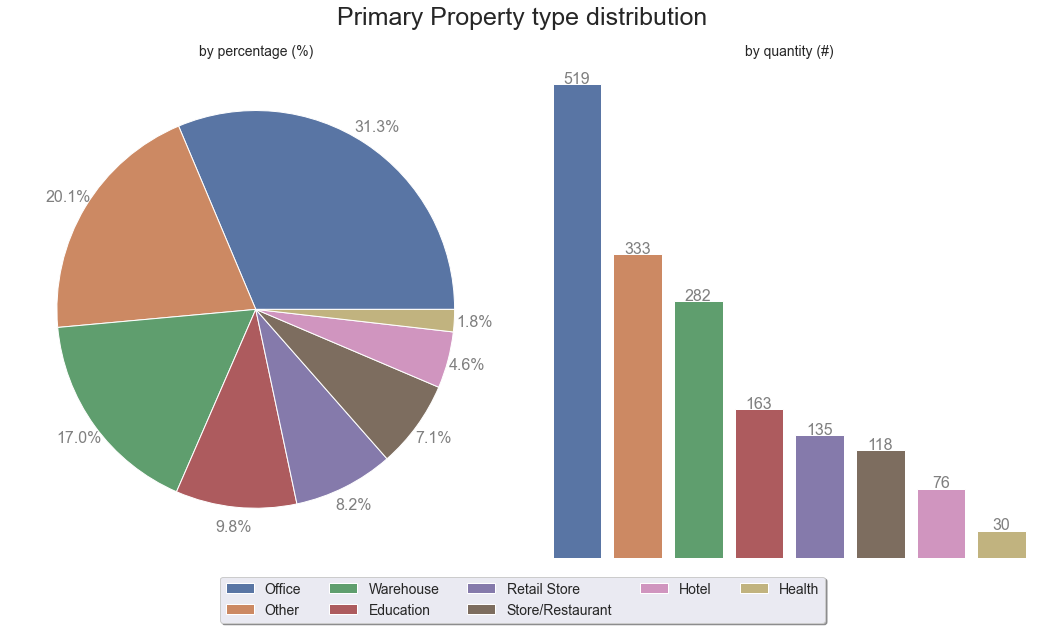

In [122]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[15,8])

fig.suptitle("Primary Property type distribution", size=25)

for lb, data, color in zip(labels_piechart, data_piechart, colors):
    ax2.bar(lb, data, label=lb, color=color)
for index, data in enumerate(data_piechart):
    plt.text(x=index, y=data+1 , s=f"{data}", horizontalalignment="center", fontdict=dict(fontsize=16, color="gray"))
ax2.set_title("by quantity (#)", fontsize=14)
ax2.axis('off')

ax1.pie(x=data_piechart, explode=explode, autopct="%1.1f%%", pctdistance=1.10, 
        textprops=textprops, colors=[color for color in colors], startangle=0)
ax1.set_title("by percentage (%)", fontsize=14)

fig.legend(labels_piechart, loc="center", ncol=5, fontsize=14, bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True)

plt.tight_layout()
plt.savefig("img/primary-property-type-distribution.png")
plt.show()

<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">5.1.2  Comparison of the targets variables in each Property type</h5>
</div>

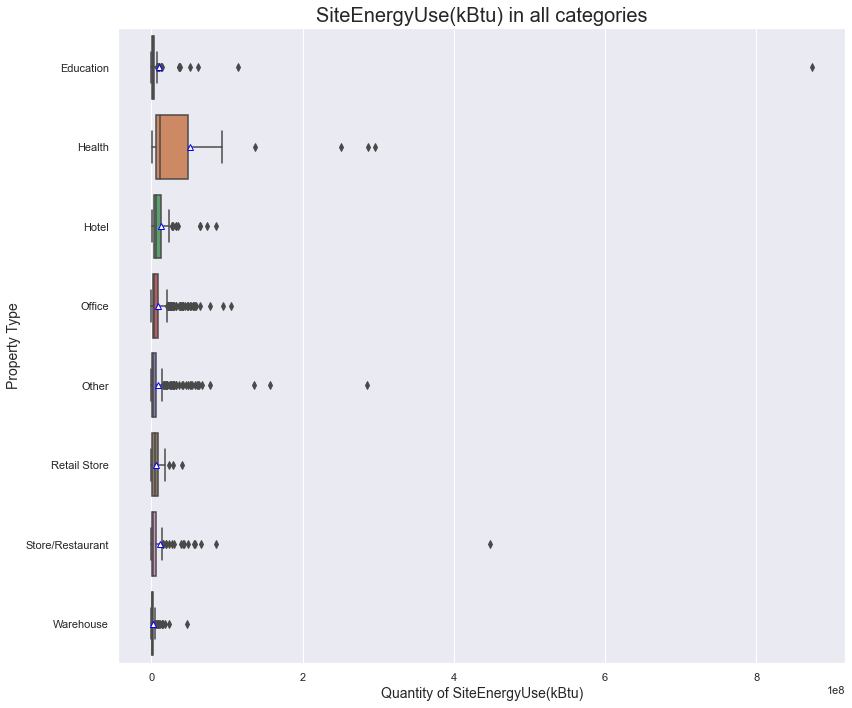

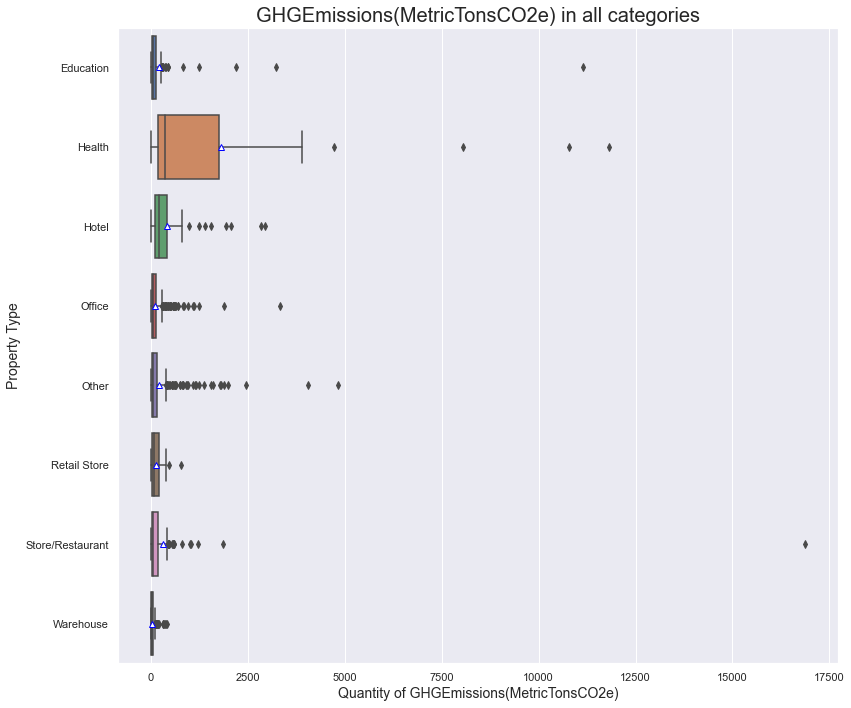

In [123]:
for var in TARGET_VARIABLES:
    if var != "ENERGYSTARScore":
        plt.figure(figsize=[12,10])
        sns.boxplot(x=df_bebcs[var], y=df_bebcs["renamed_PrimaryPropertyType"], orient="h", showmeans=True, 
                    meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
        plt.title(var + " in all categories", size=20)
        plt.ylabel("Property Type", size=14)
        plt.xlabel("Quantity of " + var, size=14)
        plt.tight_layout()
        plt.savefig("img/comparison-of-" + var + "-in-each-category.png")
        plt.show()

<div class="alert alert-block alert-success">
    <b>Observations / Conclusions</b><br/><br/>
    Building related to <b>Health</b> have a high <b>SiteEnergyUse(kBtu)</b> and <b>GHGEmissions(MetricTonsCO2e)</b>
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">5.2. Univariate analysis</h4>
</div>
<br>
<div class="alert alert-block alert-info">
    We are are going to plot all the variables <b>except</b> ENERGYSTARScore 
</div>

In [124]:
df_analysis(df_bebcs, "df_bebcs", type_analysis="complete")


Analysis of df_bebcs dataset
--------------------------------------------------------------------
- Dataset shape:                  1656 rows and 12 columns
- Total of NaN values:            534
- Percentage of NaN:              2.69 %
- Total of full duplicates rows:  0
- Total of empty rows:            0
- Total of empty columns:         0
- Unique indexes:                 True

- Type object and records by columns      ( memory usage: 211.1 KB )
--------------------------------------------------------------------


,name,type,records,unique,# NaN,% NaN,mean,min,25%,50%,75%,max,std
0,OSEBuildingID,int64,1656,1656,0,0.00000,16139.63345,1.00000,579.75000,21127.00000,24560.75000,50226.00000,13747.94898
1,Neighborhood,category,1656,13,0,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,PropertyGFABuilding(s),int64,1656,1572,0,0.00000,105871.21920,3636.00000,28356.00000,47484.50000,94479.00000,9320156.00000,284529.39591
3,PropertyGFAParking,int64,1656,326,0,0.00000,13321.64251,0.00000,0.00000,0.00000,0.00000,512608.00000,43664.74773
4,PropertyGFATotal,int64,1656,1577,0,0.00000,119192.86171,11285.00000,29398.50000,49289.50000,105070.75000,9320156.00000,298038.52446
5,SiteEnergyUse(kBtu),float64,1656,1655,0,0.00000,8563131.38206,11441.00000,1222923.50000,2512737.00000,7009066.00000,873923712.00000,30439268.96365
6,GHGEmissions(MetricTonsCO2e),float64,1656,1583,0,0.00000,186.12812,0.08000,19.52750,48.84000,139.35000,16870.98000,748.43963
8,NumberofBuildings,int64,1656,11,0,0.00000,1.13164,1.00000,1.00000,1.00000,1.00000,111.00000,2.91856
9,NumberofFloors,int64,1656,42,0,0.00000,4.13285,1.00000,1.00000,2.00000,4.00000,99.00000,6.53546
10,BuildingAge,int64,1656,113,0,0.00000,59.22645,6.00000,32.00000,56.00000,91.00000,121.00000,32.65619


In [125]:
NUMERIC_COLS = [
    "PropertyGFABuilding(s)", "PropertyGFAParking", "PropertyGFATotal", 
    "NumberofBuildings", "NumberofFloors", 
    "SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)"
]

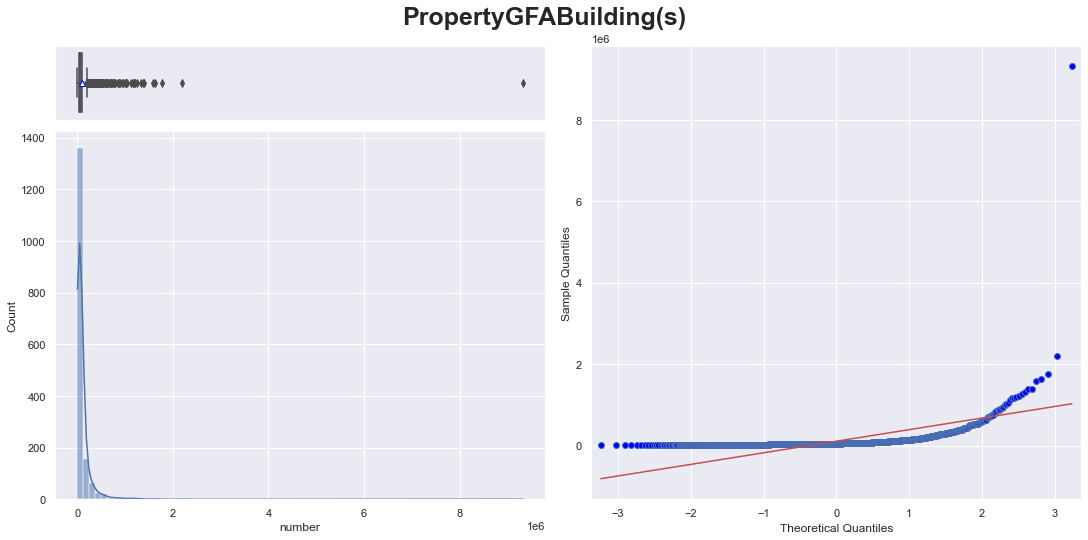


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,PropertyGFABuilding(s),Shapiro-Wilk,"Statistics=0.279, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,PropertyGFABuilding(s),D’Agostino’s K^2,"Statistics=7281.429, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,PropertyGFABuilding(s),Kolmogorov-Smirnov,"Statistics=1.000, p-value=0.000",Sample does not look Gaussian (reject H₀)


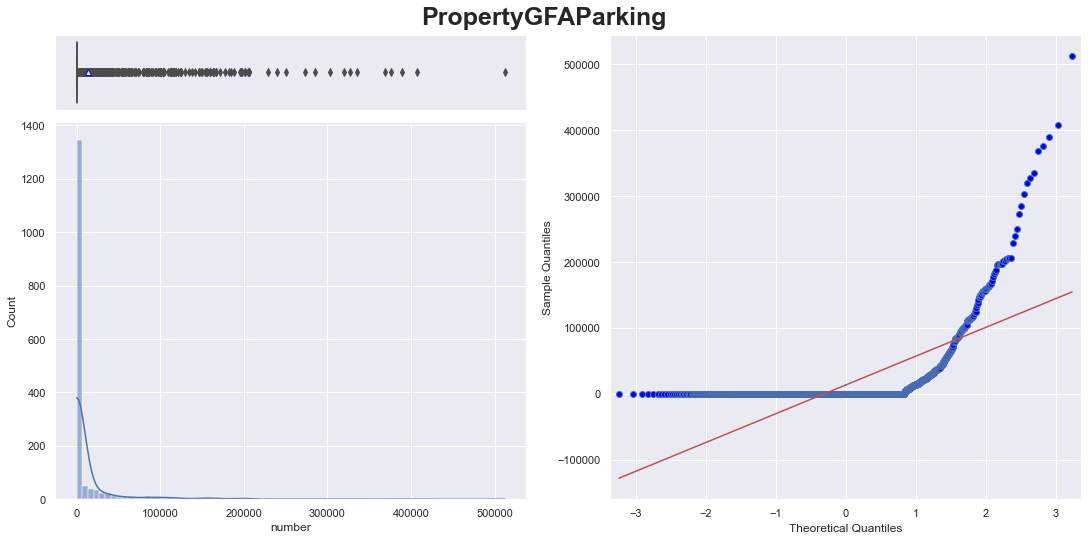


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,PropertyGFAParking,Shapiro-Wilk,"Statistics=0.346, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,PropertyGFAParking,D’Agostino’s K^2,"Statistics=3355.220, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,PropertyGFAParking,Kolmogorov-Smirnov,"Statistics=0.500, p-value=0.000",Sample does not look Gaussian (reject H₀)


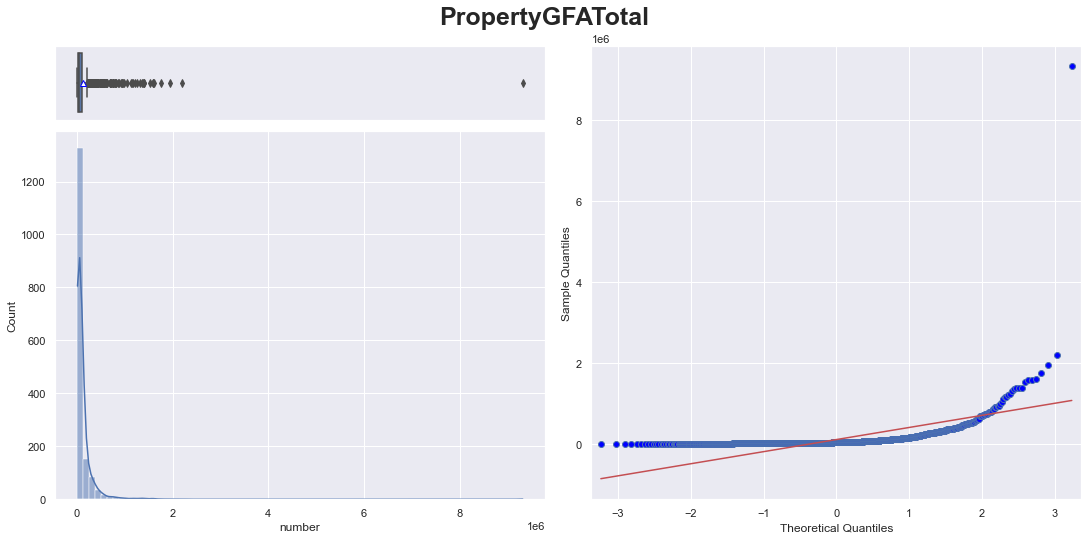


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,PropertyGFATotal,Shapiro-Wilk,"Statistics=0.319, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,PropertyGFATotal,D’Agostino’s K^2,"Statistics=6736.029, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,PropertyGFATotal,Kolmogorov-Smirnov,"Statistics=1.000, p-value=0.000",Sample does not look Gaussian (reject H₀)


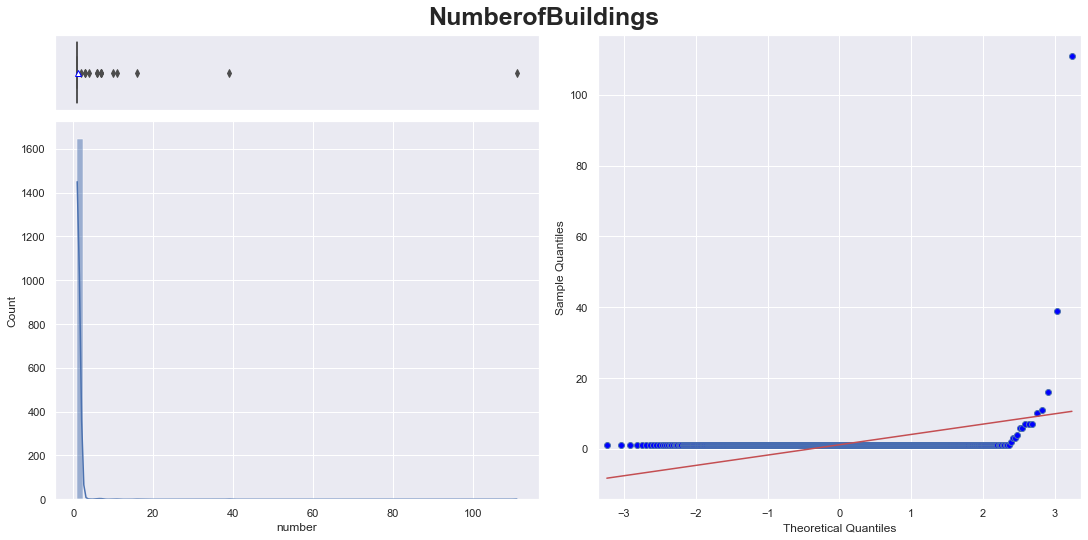


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,NumberofBuildings,Shapiro-Wilk,"Statistics=0.039, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,NumberofBuildings,D’Agostino’s K^2,"Statistics=9371.820, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,NumberofBuildings,Kolmogorov-Smirnov,"Statistics=0.826, p-value=0.000",Sample does not look Gaussian (reject H₀)


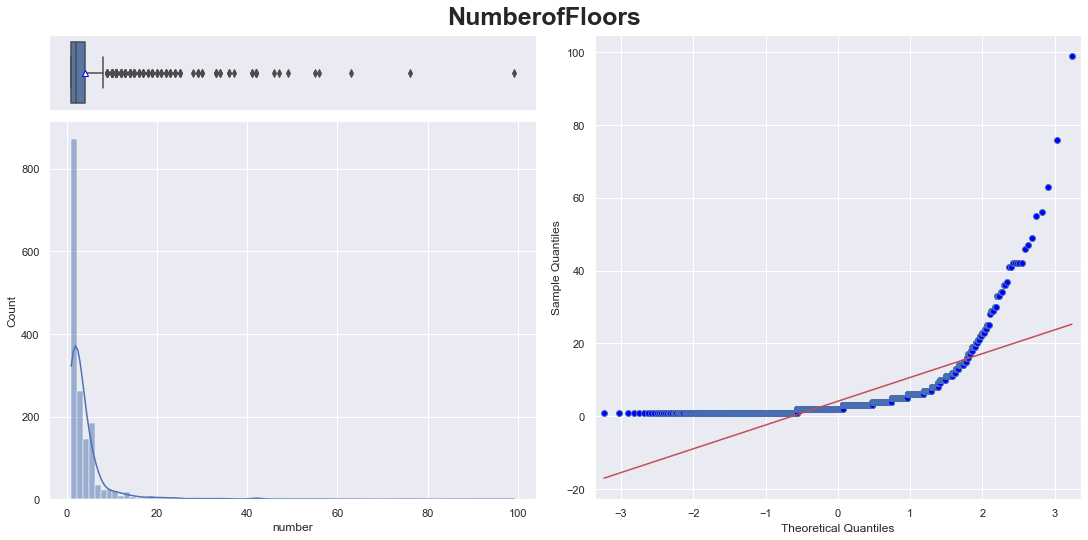


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,NumberofFloors,Shapiro-Wilk,"Statistics=0.441, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,NumberofFloors,D’Agostino’s K^2,"Statistics=3774.769, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,NumberofFloors,Kolmogorov-Smirnov,"Statistics=0.834, p-value=0.000",Sample does not look Gaussian (reject H₀)


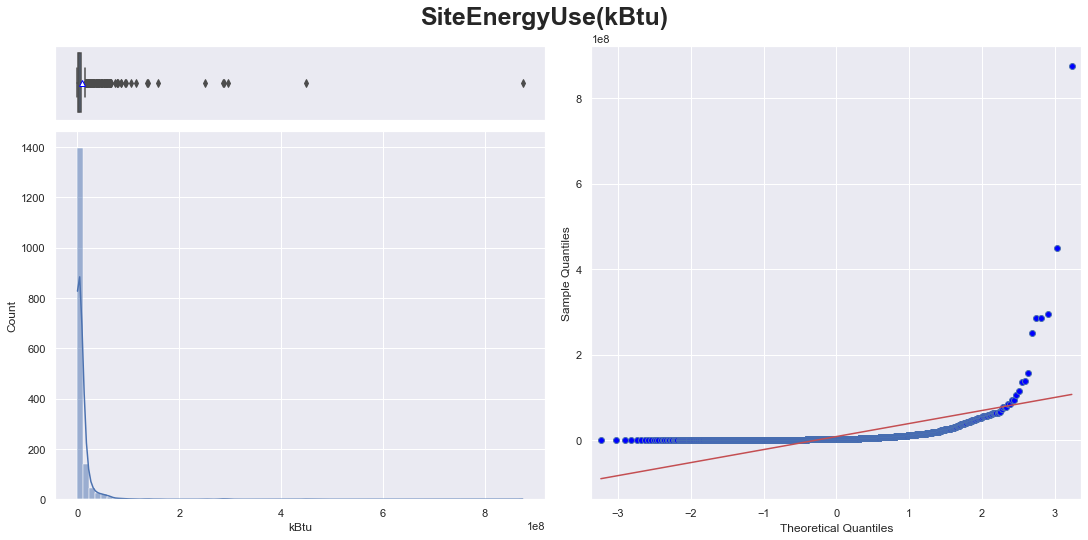


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,SiteEnergyUse(kBtu),Shapiro-Wilk,"Statistics=0.236, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,SiteEnergyUse(kBtu),D’Agostino’s K^2,"Statistics=6731.835, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,SiteEnergyUse(kBtu),Kolmogorov-Smirnov,"Statistics=0.994, p-value=0.000",Sample does not look Gaussian (reject H₀)


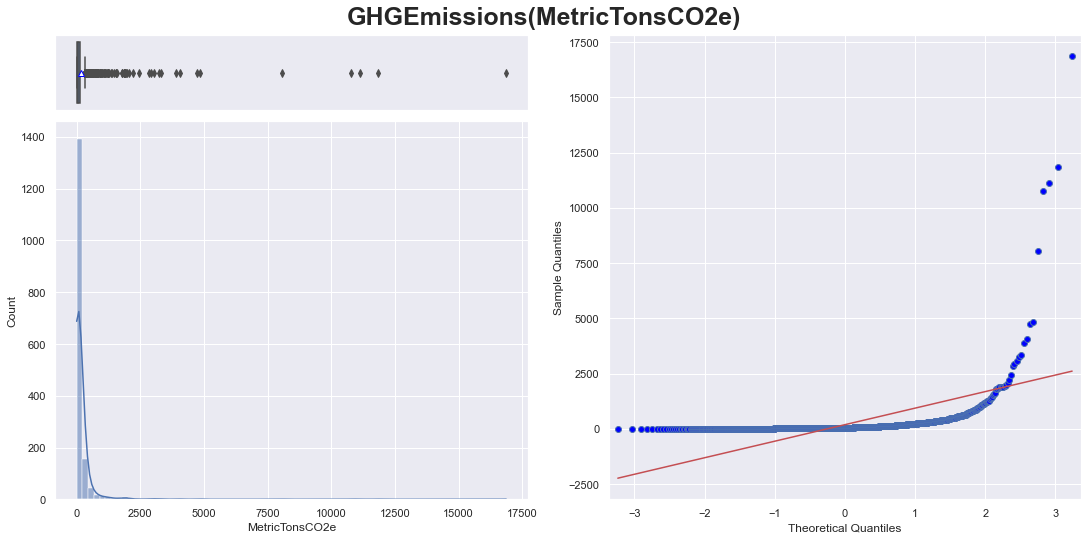


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,GHGEmissions(MetricTonsCO2e),Shapiro-Wilk,"Statistics=0.198, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,GHGEmissions(MetricTonsCO2e),D’Agostino’s K^2,"Statistics=6052.808, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,GHGEmissions(MetricTonsCO2e),Kolmogorov-Smirnov,"Statistics=0.965, p-value=0.000",Sample does not look Gaussian (reject H₀)


In [126]:
for var in NUMERIC_COLS:
    
    fig = plt.figure(constrained_layout=True, figsize=[15,7])
    fig.suptitle(var, size=25, fontweight="bold", y=1.05)
    spec = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[1, 5])

    ax_box = fig.add_subplot(spec[0, 0])
    ax_hist = fig.add_subplot(spec[1, 0])
    ax_qqplot = fig.add_subplot(spec[:, 1])

    # Boxplot
    boxplot = sns.boxplot(data=df_bebcs, x=df_bebcs[var], showmeans=True, ax=ax_box,
                          meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
    ax_box.set(xlabel="", xticks=[])
    ax_box.set(yticks=[])
    boxplot.set_title("")

    # Histplot
    sns.histplot(data=df_bebcs, x=df_bebcs[var], bins=75,  kde=True,  ax=ax_hist)
    if var == "SiteEnergyUse(kBtu)":
        ax_hist.set(xlabel="kBtu")
    elif var == "GHGEmissions(MetricTonsCO2e)":
        ax_hist.set(xlabel="MetricTonsCO2e")
    else:
        ax_hist.set(xlabel="number")

    # QQplot
    qqplot(df_bebcs[var], line='s', ax=ax_qqplot)

    plt.savefig("img/qqplot-of-" + var + ".png")
    plt.show()

    print("\nMaking the Normality Test")
    print("---------------------------------")
    normality_test(df_temp[[var]])
    print("\n")

In [127]:
pd.reset_option("display.max_colwidth") # reset width of showing cols

<div class="alert alert-block alert-success">
    <b>Observations / Conclusions</b>
    <ul style="list-style-type: square;">
        <li><b>None</b> of the analyzed variables have a <b>Normal distribution</b></li>
        <li>Based on the distribution plot, we notice that <b>all values are very close</b> what remains to be a problem</li>
    </ul>  
</div>

<div style="background-color: #506AB9;" >
    <h3 style="margin: auto; padding: 20px; color:#fff; ">XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX</h3>
</div>

<div class="alert alert-block alert-danger">
    <b>Flag Position</b>
    
    asignar por la mediana el numero de pisos segun el tipo de edificio
</div>

In [128]:
XXXXX

    "PropertyGFABuilding(s)", "PropertyGFAParking", "PropertyGFATotal", 
    "NumberofBuildings", "NumberofFloors", 
    "SiteEnergyUse(kBtu)", "GHGEmissions(MetricTonsCO2e)"

IndentationError: unexpected indent (<ipython-input-128-a07cb3732cd1>, line 3)

<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">5.2.1 Log Normalization target variables</h5>
</div>
<br>
<div class="alert alert-block alert-info">
     Based on the <b>Univariate analysis</b> where we note that <b>none</b> of the analyzed variables have a <b>Normal distribution</b>
     and <b>all their values are very close</b> so, we are going to aplly the <b>Logarithmic transformation</b> in these variables to get a <b>better Normal distribution</b> of these values
</div>

In [170]:
def highlight_max(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    #attr = 'background-color: {}'.format(color) + 'color: black'
    attr = 'background-color: yellow; color: black'
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_max = data == data.max()
        return [attr if v else '' for v in is_max]
    else:  # from .apply(axis=None)
        is_max = data == data.max().max()
        return pd.DataFrame(np.where(is_max, attr, ''),
                            index=data.index, columns=data.columns)

In [167]:
for col in NUMERIC_COLS:
    df_bebcs[col + "_log"] = np.log(df_bebcs[col] + 1)
    df_bebcs[col + "_log2"] = np.log2(df_bebcs[col] + 1)
    df_bebcs[col + "_log10"] = np.log10(df_bebcs[col] + 1)

In [168]:
df_bebcs["PropertyGFABuilding(s)"].var()

80956977137.648

In [172]:

for col in NUMERIC_COLS:
    print("\n######################################################################")
    print("Showing the variance of the data", col)
    print("######################################################################")
    df_temp = pd.DataFrame(df_bebcs[[col + "_log", col + "_log2", col + "_log10"]].var(), 
                           columns=["variance"])
    
    display(df_temp.style.apply(highlight_max))
    print("\n")


######################################################################
Showing the variance of the data PropertyGFABuilding(s)
######################################################################


,variance
PropertyGFABuilding(s)_log,0.833209
PropertyGFABuilding(s)_log2,1.734216
PropertyGFABuilding(s)_log10,0.157153





######################################################################
Showing the variance of the data PropertyGFAParking
######################################################################


,variance
PropertyGFAParking_log,17.987797
PropertyGFAParking_log2,37.439242
PropertyGFAParking_log10,3.392709





######################################################################
Showing the variance of the data PropertyGFATotal
######################################################################


,variance
PropertyGFATotal_log,0.920076
PropertyGFATotal_log2,1.915018
PropertyGFATotal_log10,0.173537





######################################################################
Showing the variance of the data NumberofBuildings
######################################################################


,variance
NumberofBuildings_log,0.028067
NumberofBuildings_log2,0.058417
NumberofBuildings_log10,0.005294





######################################################################
Showing the variance of the data NumberofFloors
######################################################################


,variance
NumberofFloors_log,0.417305
NumberofFloors_log2,0.868566
NumberofFloors_log10,0.078709





######################################################################
Showing the variance of the data SiteEnergyUse(kBtu)
######################################################################


,variance
SiteEnergyUse(kBtu)_log,1.791332
SiteEnergyUse(kBtu)_log2,3.728422
SiteEnergyUse(kBtu)_log10,0.337866





######################################################################
Showing the variance of the data GHGEmissions(MetricTonsCO2e)
######################################################################


,variance
GHGEmissions(MetricTonsCO2e)_log,2.118748
GHGEmissions(MetricTonsCO2e)_log2,4.409897
GHGEmissions(MetricTonsCO2e)_log10,0.399621


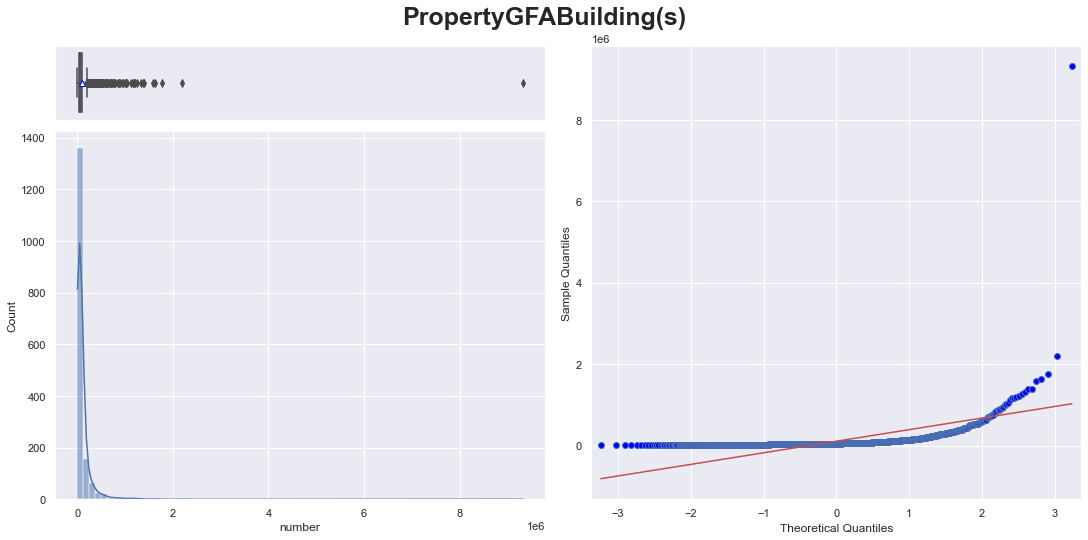


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,PropertyGFABuilding(s),Shapiro-Wilk,"Statistics=0.279, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,PropertyGFABuilding(s),D’Agostino’s K^2,"Statistics=7281.429, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,PropertyGFABuilding(s),Kolmogorov-Smirnov,"Statistics=1.000, p-value=0.000",Sample does not look Gaussian (reject H₀)


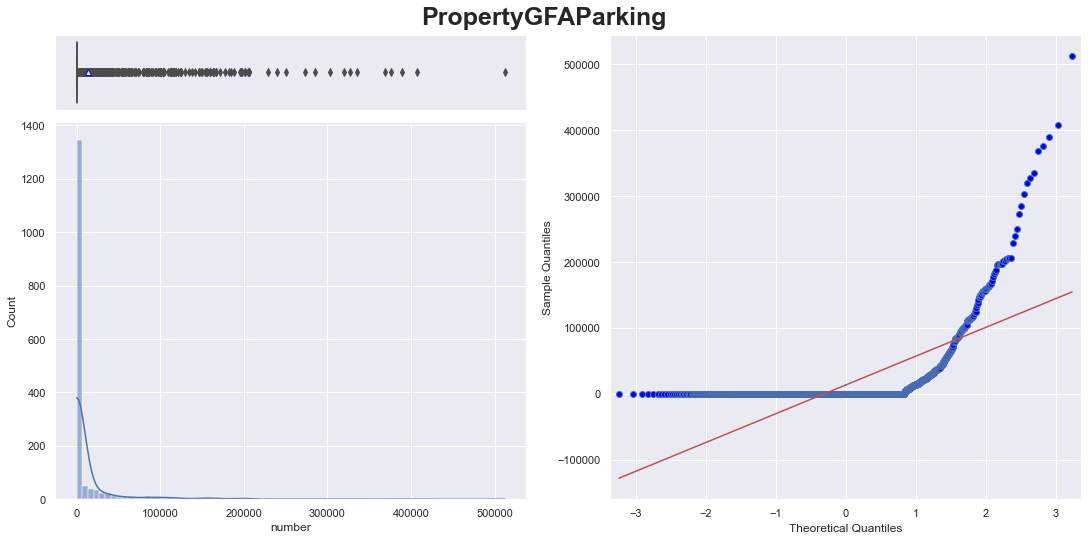


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,PropertyGFAParking,Shapiro-Wilk,"Statistics=0.346, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,PropertyGFAParking,D’Agostino’s K^2,"Statistics=3355.220, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,PropertyGFAParking,Kolmogorov-Smirnov,"Statistics=0.500, p-value=0.000",Sample does not look Gaussian (reject H₀)


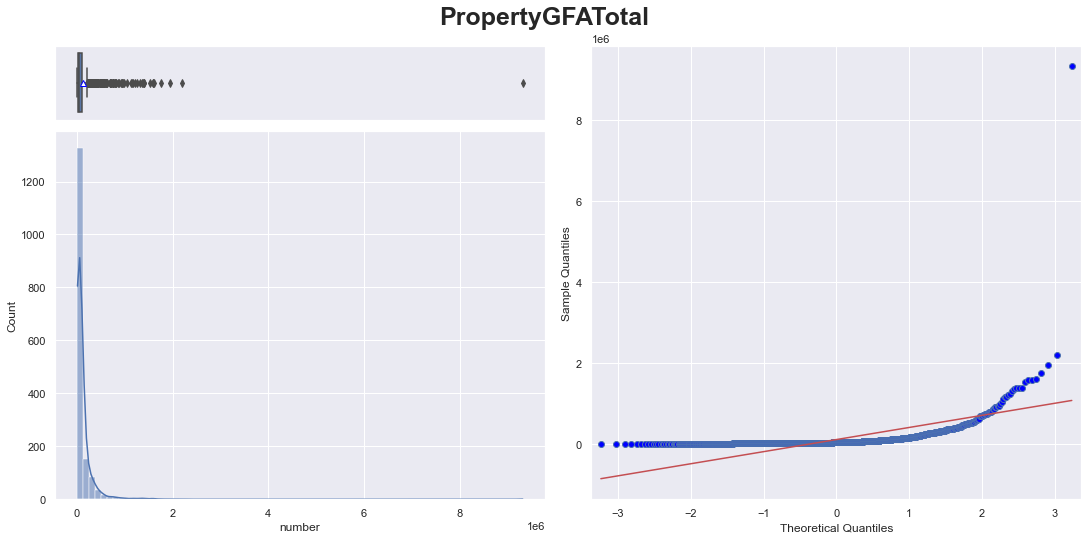


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,PropertyGFATotal,Shapiro-Wilk,"Statistics=0.319, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,PropertyGFATotal,D’Agostino’s K^2,"Statistics=6736.029, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,PropertyGFATotal,Kolmogorov-Smirnov,"Statistics=1.000, p-value=0.000",Sample does not look Gaussian (reject H₀)


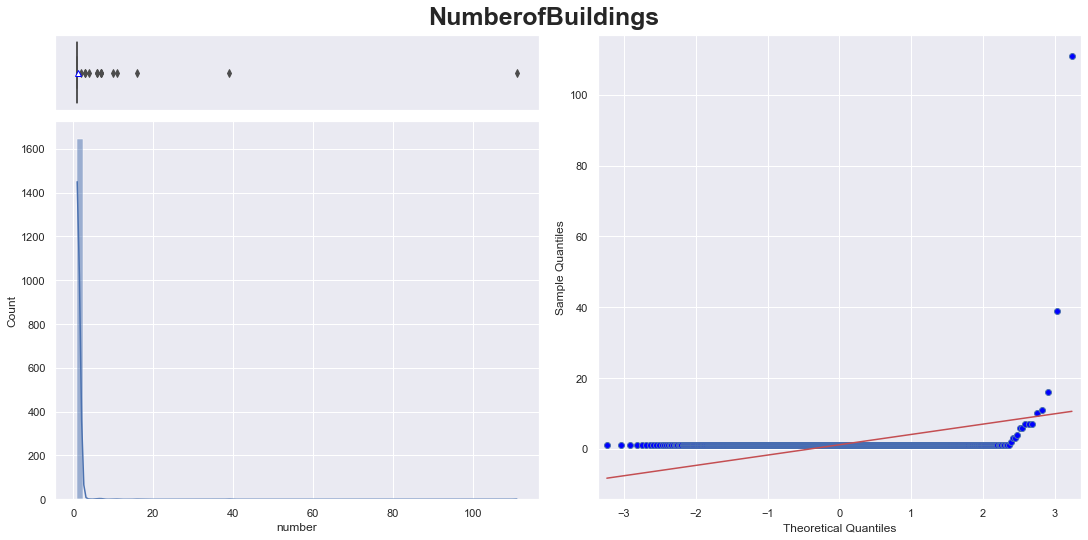


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,NumberofBuildings,Shapiro-Wilk,"Statistics=0.039, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,NumberofBuildings,D’Agostino’s K^2,"Statistics=9371.820, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,NumberofBuildings,Kolmogorov-Smirnov,"Statistics=0.826, p-value=0.000",Sample does not look Gaussian (reject H₀)


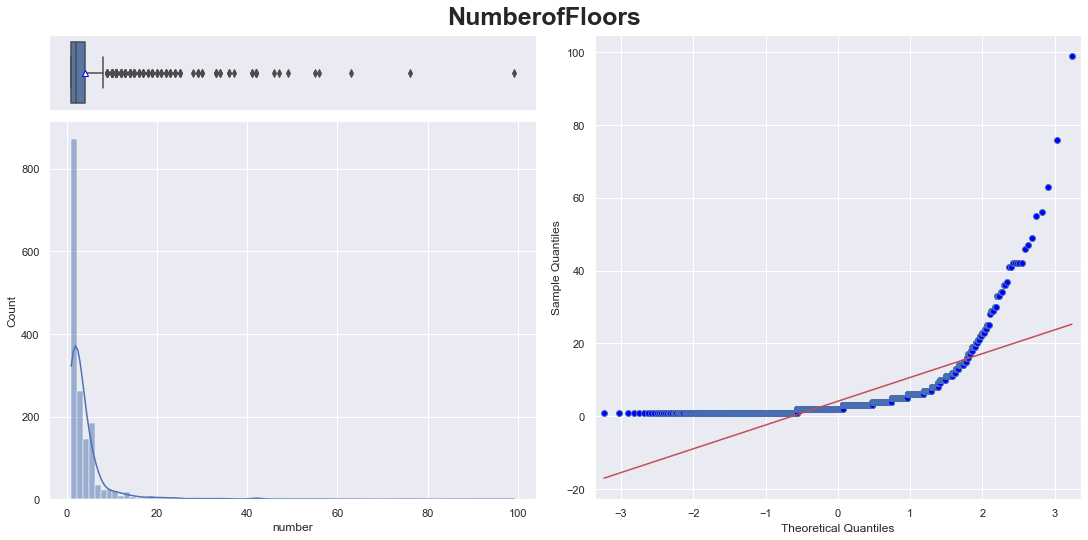


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,NumberofFloors,Shapiro-Wilk,"Statistics=0.441, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,NumberofFloors,D’Agostino’s K^2,"Statistics=3774.769, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,NumberofFloors,Kolmogorov-Smirnov,"Statistics=0.834, p-value=0.000",Sample does not look Gaussian (reject H₀)


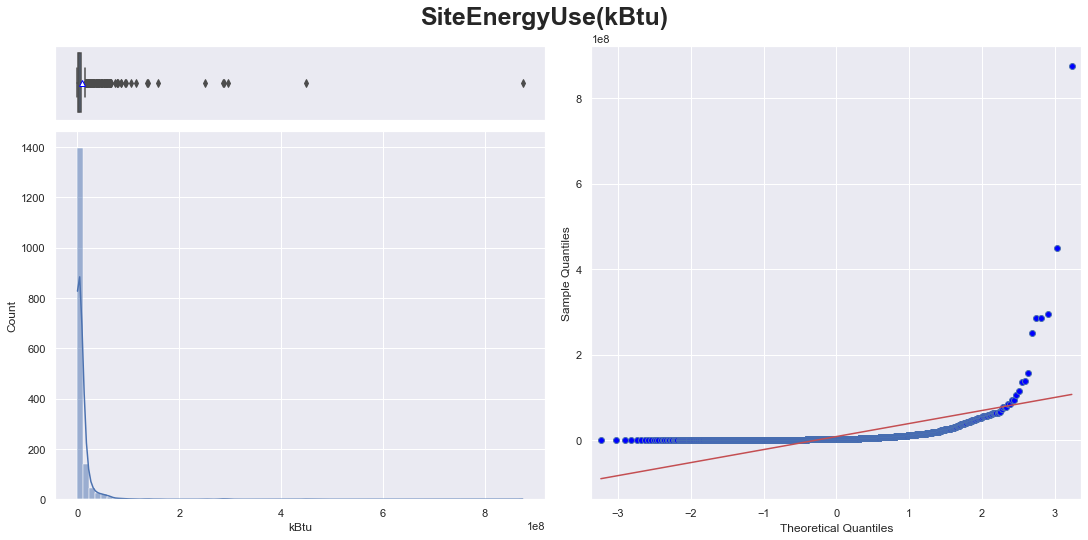


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,SiteEnergyUse(kBtu),Shapiro-Wilk,"Statistics=0.236, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,SiteEnergyUse(kBtu),D’Agostino’s K^2,"Statistics=6731.835, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,SiteEnergyUse(kBtu),Kolmogorov-Smirnov,"Statistics=0.994, p-value=0.000",Sample does not look Gaussian (reject H₀)


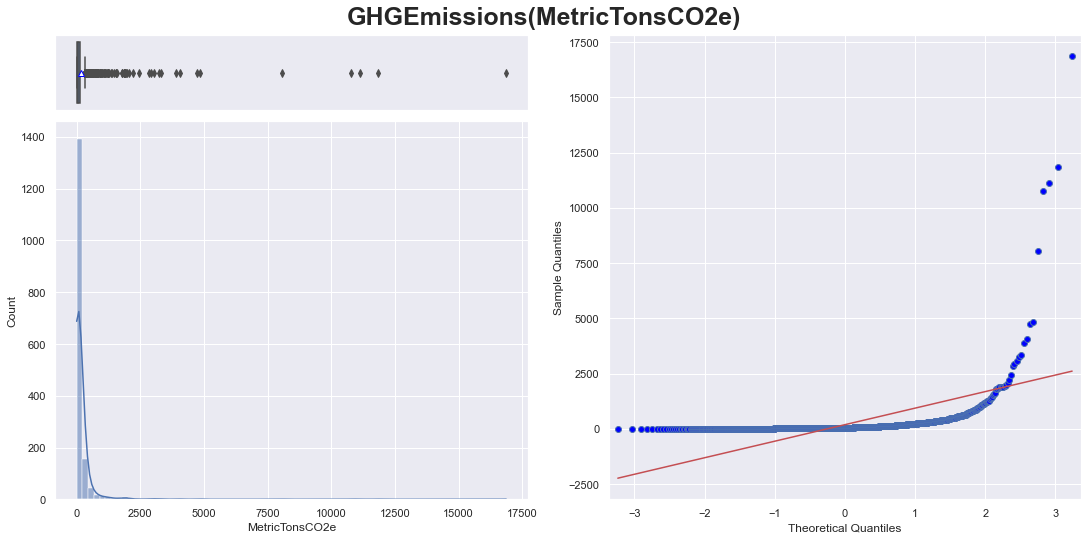


Making the Normality Test
---------------------------------


,variable,normality test,result,hypothesis
0,GHGEmissions(MetricTonsCO2e),Shapiro-Wilk,"Statistics=0.198, p-value=0.000",Sample does not look Gaussian (reject H₀)
1,GHGEmissions(MetricTonsCO2e),D’Agostino’s K^2,"Statistics=6052.808, p-value=0.000",Sample does not look Gaussian (reject H₀)
2,GHGEmissions(MetricTonsCO2e),Kolmogorov-Smirnov,"Statistics=0.965, p-value=0.000",Sample does not look Gaussian (reject H₀)


In [126]:
for var in NUMERIC_COLS:
    
    fig = plt.figure(constrained_layout=True, figsize=[15,7])
    fig.suptitle(var, size=25, fontweight="bold", y=1.05)
    spec = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[1, 5])

    ax_box = fig.add_subplot(spec[0, 0])
    ax_hist = fig.add_subplot(spec[1, 0])
    ax_qqplot = fig.add_subplot(spec[:, 1])

    # Boxplot
    boxplot = sns.boxplot(data=df_bebcs, x=df_bebcs[var], showmeans=True, ax=ax_box,
                          meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
    ax_box.set(xlabel="", xticks=[])
    ax_box.set(yticks=[])
    boxplot.set_title("")

    # Histplot
    sns.histplot(data=df_bebcs, x=df_bebcs[var], bins=75,  kde=True,  ax=ax_hist)
    if var == "SiteEnergyUse(kBtu)":
        ax_hist.set(xlabel="kBtu")
    elif var == "GHGEmissions(MetricTonsCO2e)":
        ax_hist.set(xlabel="MetricTonsCO2e")
    else:
        ax_hist.set(xlabel="number")

    # QQplot
    qqplot(df_bebcs[var], line='s', ax=ax_qqplot)

    plt.savefig("img/qqplot-of-" + var + ".png")
    plt.show()

    print("\nMaking the Normality Test")
    print("---------------------------------")
    normality_test(df_temp[[var]])
    print("\n")

In [ ]:
df_bebcs["SiteEnergyUse(kBtu)_log"] = np.log(df_bebcs["SiteEnergyUse(kBtu)"])
df_bebcs["GHGEmissions(MetricTonsCO2e)_log"] = np.log(df_bebcs["GHGEmissions(MetricTonsCO2e)"])

df_bebcs["SiteEnergyUse(kBtu)_log2"] = np.log2(df_bebcs["SiteEnergyUse(kBtu)"])
df_bebcs["GHGEmissions(MetricTonsCO2e)_log2"] = np.log2(df_bebcs["GHGEmissions(MetricTonsCO2e)"])

df_bebcs["SiteEnergyUse(kBtu)_log10"] = np.log10(df_bebcs["SiteEnergyUse(kBtu)"])
df_bebcs["GHGEmissions(MetricTonsCO2e)_log10"] = np.log10(df_bebcs["GHGEmissions(MetricTonsCO2e)"])

In [ ]:
LOG_VARIABLES_COMPARISON = ["SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log", "SiteEnergyUse(kBtu)_log2", "SiteEnergyUse(kBtu)_log10",
                            "GHGEmissions(MetricTonsCO2e)", "GHGEmissions(MetricTonsCO2e)_log", "GHGEmissions(MetricTonsCO2e)_log2", "GHGEmissions(MetricTonsCO2e)_log10"
]

# Filtering by non missing-values to can plot the QQplot
df_temp = pd.DataFrame(df_bebcs[df_bebcs[LOG_VARIABLES_COMPARISON].notnull().all(axis=1)])
        
for var in LOG_VARIABLES_COMPARISON:
    
    if "log" not in var:
        print("\n######################################################################")
        print("Making the Normality Test for", var)
        print("######################################################################\n")
        normality_test(df_temp[[var]])
        print("\n")
    
    fig = plt.figure(constrained_layout=True, figsize=[14,7])
    fig.suptitle(var, size=25, fontweight="bold", y=1.05)
    spec = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1], height_ratios=[1, 5])

    ax_box = fig.add_subplot(spec[0, 0])
    ax_hist = fig.add_subplot(spec[1, 0])
    ax_qqplot = fig.add_subplot(spec[:, 1])

    # Boxplot
    boxplot = sns.boxplot(data=df_temp, x=df_temp[var], showmeans=True, ax=ax_box,
                          meanprops={"markerfacecolor":"white", "markeredgecolor":"blue"})
    ax_box.set(xlabel="", xticks=[])
    ax_box.set(yticks=[])
    boxplot.set_title("")

    # Histplot
    sns.histplot(data=df_temp, x=df_temp[var], bins=75,  kde=True,  ax=ax_hist)
    if "SiteEnergyUse" in var:
        ax_hist.set(xlabel="kBtu")
    else:
        ax_hist.set(xlabel="MetricTonsCO2e")

    # QQplot
    qqplot(df_temp[var], line='s', ax=ax_qqplot)

    plt.savefig("img/qqplot-of-" + var + ".png")
    plt.show()
    
    if "log10" in var:
        print("\ndata variance of", var[:-12])
        display(df_temp[["SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log", "SiteEnergyUse(kBtu)_log2", "SiteEnergyUse(kBtu)_log10"]].var())
        print("\n")

<div class="alert alert-block alert-success">
    After making <b>log transformation</b>, we got that <b>log2 has the highest variance</b> for both target variables. 
</div>

In [ ]:
COL_TO_DROP_AFTER_LOG = [
    "SiteEnergyUse(kBtu)_log", "SiteEnergyUse(kBtu)_log10", 
    "GHGEmissions(MetricTonsCO2e)_log", "GHGEmissions(MetricTonsCO2e)_log10"
]

In [ ]:
df_bebcs.drop(labels=COL_TO_DROP_AFTER_LOG, axis=1, inplace=True)

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">5.3 Multivariate Analysis</h4>
</div>

In [ ]:
df_analysis(df_bebcs, "df_bebcs", type_analysis="complete")

<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">5.3.1 Correlation Matrix</h5>
</div>

<div class="alert alert-block alert-info">
    We are going to make the Correlation matrix for some numeric features
</div>

In [ ]:
FEATURES_IN_MATRIX_CORR = [
    "NumberofBuildings", "NumberofFloors", "PropertyGFABuilding(s)", "PropertyGFAParking", "PropertyGFATotal", "BuildingAge",
    "SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log2", "GHGEmissions(MetricTonsCO2e)", "GHGEmissions(MetricTonsCO2e)_log2"
]

In [ ]:
df_correlation_matrix = pd.DataFrame(df_bebcs[FEATURES_IN_MATRIX_CORR].corr()).round(2)

In [ ]:
mask = np.zeros_like(df_correlation_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True 

In [ ]:
plt.figure(figsize=(16,8))
plt.title("Pearson correlation between all features", size=20)

ax = sns.heatmap(df_correlation_matrix, mask=mask, vmin=-1, cmap="mako_r",
                annot=True, annot_kws={"size": 14})

plt.xticks(rotation=25, size=14, horizontalalignment="right")
plt.yticks(rotation=0, size=14)
plt.tight_layout()
plt.savefig("img/pearson-correlation-between-features.png")
plt.show()

<div class="alert alert-block alert-success">
    <b>Observations / Conclusions</b>
    
        <ul style="list-style-type: square;">
            <li><b>Target features transformed</b> have a <b>different correlation</b> between them compared to the<b> original features</b></li>
            <li>Fields related to <b>gross floor area</b> have a strong <b>correlation</b> with <b>SiteEnergyUse(kBtu)</b> as well <b>NumberofBuildings</b></li>
            <li><b>Age of building</b> have a <b>weak correlation</b> with the <b>target features</b></li>
        </ul>               
</div>

<div style="background-color: #6D83C5;" >
    <h5 style="margin: auto; padding: 20px; color:#fff; ">5.3.2. Correlation Matrix for ENERGYSTARScore</h5>
</div>

<div class="alert alert-block alert-info">
    We are going to add a ENERGYSTARScore to make the Correlation matrix
</div>

In [ ]:
FEATURES_IN_MATRIX_CORR = [
    "NumberofBuildings", "NumberofFloors", "PropertyGFABuilding(s)", "PropertyGFAParking", "PropertyGFATotal", "BuildingAge",
    "SiteEnergyUse(kBtu)", "SiteEnergyUse(kBtu)_log2", "GHGEmissions(MetricTonsCO2e)", "GHGEmissions(MetricTonsCO2e)_log2", "ENERGYSTARScore"
]

<div class="alert alert-block alert-info">
    Filtering subset based on not null ENERGYSTARScore
</div>

In [ ]:
df_correlation_matrix = df_bebcs[df_bebcs["ENERGYSTARScore"].notnull()].copy()

In [ ]:
df_correlation_matrix = pd.DataFrame(df_correlation_matrix[FEATURES_IN_MATRIX_CORR].corr()).round(2)

In [ ]:
mask = np.zeros_like(df_correlation_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True 

In [ ]:
plt.figure(figsize=(16,8))
plt.title("Pearson correlation between with ENERGYSTARScore", size=20)

ax = sns.heatmap(df_correlation_matrix, mask=mask, vmin=-1, cmap="mako_r",
                annot=True, annot_kws={"size": 14})

plt.xticks(rotation=25, size=14, horizontalalignment="right")
plt.yticks(rotation=0, size=14)
plt.tight_layout()
plt.savefig("img/pearson-correlation-with-ENERGYSTARScore.png")
plt.show()

<div class="alert alert-block alert-success">
    <b>Observations / Conclusions</b>
    
        <ul style="list-style-type: square;">
            <li><b>ENERGYSTARScore</b> has a weak correlation with the <b>target features</b></li>
        </ul>               
</div>

<div style="background-color: #6D83C5;" >
    <h4 style="margin: auto; padding: 20px; color:#fff; ">5.4. Principal component analysis - PCA</h4>
</div>

In [ ]:
df_analysis(df_bebcs, "df_bebcs", type_analysis="complete")

<div class="alert alert-block alert-info">
    We are <b>not</b> going to <b>consider</b> the following features
    <ul style="list-style-type: square;">
        <li><b>OSEBuildingID:</b> Not interesting for the mission</li>
        <li><b>SiteEnergyUse(kBtu): </b> Features target</li>
        <li><b>SiteEnergyUse(kBtu)_log2: </b>Transformed features target</li>
        <li><b>GHGEmissions(MetricTonsCO2e): </b> Features target</li>
        <li><b>GHGEmissions(MetricTonsCO2e)_log2: </b> Transformed features target</li>
        <li><b>ENERGYSTARScore: </b>Other features</li>
    </ul>  
</div>
<div class="alert alert-block alert-info">
    <b>Encoding</b> through <b>LabelEncoder</b> the booleans features
</div>

In [ ]:
le = LabelEncoder()

In [ ]:
df_le = df_bebcs.iloc[:,13:16].apply(le.fit_transform)

In [ ]:
df_le.head(5)

<div class="alert alert-block alert-info">
    <b>Encoding</b> through <b>OrdinalEncoder</b> because the order matters
</div>

In [ ]:
enc = OrdinalEncoder(categories=[["Low", "Medium", "High"]])

In [ ]:
array_enc = enc.fit_transform(df_bebcs[["CO2EmissionsLevel"]])

In [ ]:
df_enc = pd.DataFrame(array_enc, index=df_bebcs.index, columns=["CO2EmissionsLevel"])

In [ ]:
df_enc.head(5)

<div class="alert alert-block alert-info">
    <b>Encoding</b> through <b>OneHotEncoder</b> the categorical features
</div>

In [ ]:
ohe = OneHotEncoder(sparse=False)

In [ ]:
array_ohe = ohe.fit_transform(df_bebcs[["renamed_PrimaryPropertyType"]])

In [ ]:
df_ohe_property_type = pd.DataFrame(array_ohe, index=df_bebcs.index)
df_ohe_property_type = df_ohe_property_type.add_prefix("property_type_")

In [ ]:
array_ohe = ohe.fit_transform(df_bebcs[["Neighborhood"]])

In [ ]:
df_ohe_neighborhood = pd.DataFrame(array_ohe, index=df_bebcs.index)
df_ohe_neighborhood = df_ohe_neighborhood.add_prefix("neighborhood_")

<div class="alert alert-block alert-info">
    <b>Normalizing</b> the numeric features <br>
    None of the numerical variables follow a normal distribution, so we will use StandardScaler
    
</div>

In [ ]:
df_numeric_features = df_bebcs.loc[:, ["NumberofFloors", "NumberofBuildings", "PropertyGFATotal", "PropertyGFAParking", "PropertyGFABuilding(s)", "BuildingAge"]]

In [ ]:
scaler = StandardScaler()

In [ ]:
scaler_features = scaler.fit_transform(df_numeric_features)

In [ ]:
df_scaler = pd.DataFrame(scaler_features, index=df_numeric_features.index, columns=df_numeric_features.columns)
df_scaler.head(5)

<div class="alert alert-block alert-info">
   Numbers of components to calculate to PCA            
</div>

In [ ]:
n_comp = 6

<div class="alert alert-block alert-info">
    Selecting the features to analyse with PCA
</div>

In [ ]:
X = df_numeric_features.values
index_values = df_numeric_features.index
features = df_numeric_features.columns

<div class="alert alert-block alert-info">
   Principal components determination      
</div>

In [ ]:
pca = PCA(n_components=n_comp).fit(X)

In [ ]:
df_pca = pd.DataFrame(pca.components_, 
                      index=["PC" + str(i+1) for i in range(n_comp)],
                      columns=features ).T

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Principal components coefficients", size=20)

ax = sns.heatmap(df_pca, vmin=-1, vmax=1, center=0, cmap="mako_r",
                annot=True, annot_kws={"size": 14}, fmt=".5f")

plt.xticks(size=14)
plt.yticks(size=14)
plt.tight_layout()
plt.savefig("img/principal-components-coefficients.png")
plt.show()

<div class="alert alert-block alert-success">
    <b>Observations / Conclusions</b><br>
    
    In this graph we have the influence of each of the variables for each component
    
    <ul style="list-style-type: square;">
        <li><b>PC1</b> has a influence by <b>PropertyGFATotal</b> and <b>PropertyGFABuilding(s)</b></li>
        <li><b>PC2</b> has a influence by <b>PropertyGFABuilding(s)</b></li>
        <li><b>BuildingAge</b> has a influence in <b>PC3</b></li>
        <li><b>NumberofFloors</b> and <b>NumberofBuildings</b> have an influence on <b>PC4</b> and <b>PC5</b>respectively</li>
        <li><b>PC5</b> has a influence by <b>PropertyGFAParking</b> and <b>PropertyGFABuilding(s)</b></li>
    </ul>     
</div>

<div class="alert alert-block alert-info">
    Plotting the <b>Scree of eigenvalues</b>
</div>

In [ ]:
scree = pca.explained_variance_ratio_*100

fig = plt.subplots(figsize=(10, 7))
plot_bar = sns.barplot(x=df_pca.columns, y=scree)
for p in plot_bar.patches:
    plot_bar.annotate(format(p.get_height(), ".1f"), (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha="center", va="bottom", xytext=(0, -15), textcoords="offset points", color="white")
plot_line = sns.lineplot(x=df_pca.columns, y=scree.cumsum(), marker="o", color="red")

for x, y in zip(df_pca.columns, scree.cumsum()):
    plot_line.text(x, y, "{:.2f}".format(y), ha="right", va="bottom")

plt.xlabel("Rank of the inertia axis", size=14)
plt.ylabel("% of inertia", size=14)
plt.title("Scree of eigenvalues", size=20)
plt.tight_layout()
plt.savefig("img/scree-of-eigenvalues.png")
plt.show()

<div class="alert alert-block alert-success">
    <b>Observations / Conclusions</b>
    
    <ul style="list-style-type: square;">
        <li><b>PC1</b>describes <b>98.5%</b> of the variance of the data.</li>
    </ul>     
</div>

<div class="alert alert-block alert-info">
    Plotting the <b>Correlation Circle</b>
</div>

In [ ]:
display_circles(pca.components_, n_comp, pca, [(0,1),(2,3),(4,5)], labels=np.array(features))

<div class="alert alert-block alert-info">
    Keeping the <b>90% of the variance of the components</b>
</div>

In [ ]:
var_threshold=0.99

# Processing the PCA
pca = decomposition.PCA()
pca.fit(X)

# Getting the explained variance ratio for each principal component
scree = pca.explained_variance_ratio_

# Getting the number of principal components to reach variance thresholds
mask = scree.cumsum() > var_threshold
nb_selected_components = len(scree[~mask]) + 1
print("Number of selected components:", nb_selected_components)

# Compute and displays the actual ratio of explained variance
explained_variance_sum = scree.cumsum()[nb_selected_components-1]
print("Cumulative explained variance:  {:.2f}%".format(explained_variance_sum*100))

# Getting the projection of the data on the first components
X_PCA = pca.transform(X)[:,:nb_selected_components]

In [ ]:
COL_TO_PC = ["PC1", "PC2"]

In [ ]:
df_worked = pd.DataFrame(data=X_PCA, columns=COL_TO_PC, index=index_values)

In [ ]:
df_worked.head(5)

<div class="alert alert-block alert-info">
    <b>Concatenating</b> dataframes 
</div>

In [ ]:
df_subset = pd.concat([df_worked, df_le, df_enc, df_ohe_property_type, df_ohe_neighborhood], axis=1)

In [ ]:
df_subset.head()

In [ ]:
df_subset = pd.concat([df_subset, df_bebcs[["SiteEnergyUse(kBtu)_log2", "GHGEmissions(MetricTonsCO2e)_log2"]], df_bebcs[OTHER_VARIABLE]], axis=1)

In [ ]:
df_subset.head()

In [ ]:
df_subset.shape

In [ ]:
df_subset.to_csv("datasets\df_cleaned_final.csv", index=False)